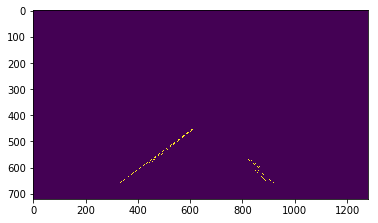

[254, 720, 637, 432]
[992, 720, 648, 432]


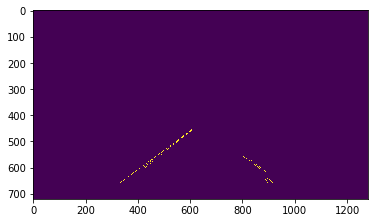

[265, 720, 638, 432]
[265, 720, 638, 432]


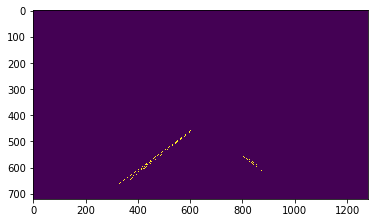

[260, 720, 640, 432]
[1016, 720, 638, 432]


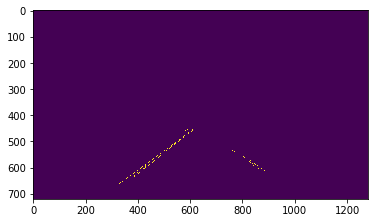

[268, 720, 641, 432]
[268, 720, 641, 432]


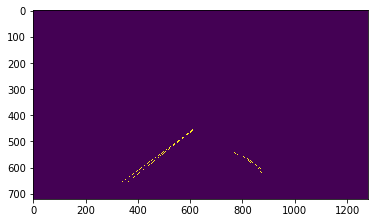

[267, 720, 642, 432]
[267, 720, 642, 432]


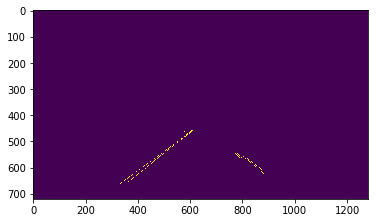

[267, 720, 643, 432]
[1003, 720, 648, 432]


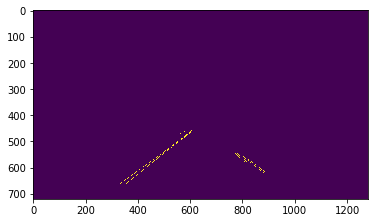

[268, 720, 643, 432]
[1003, 720, 647, 432]


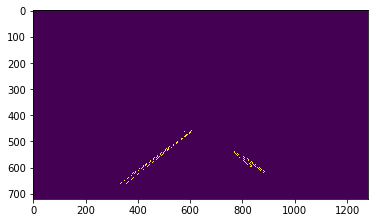

[264, 720, 644, 432]
[984, 720, 648, 432]


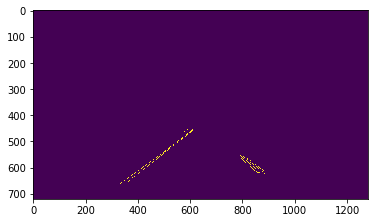

[266, 720, 644, 432]
[996, 720, 646, 432]


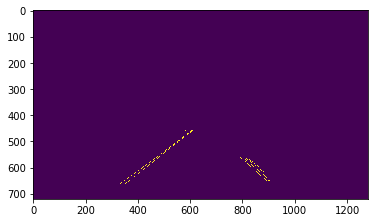

[269, 720, 642, 432]
[990, 720, 647, 432]


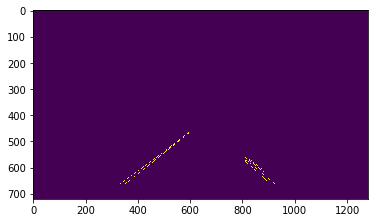

[270, 720, 640, 432]
[985, 720, 644, 432]


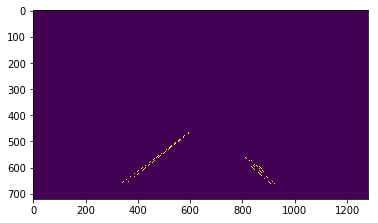

[270, 720, 639, 432]
[992, 720, 650, 432]


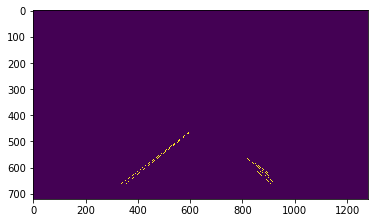

[268, 720, 642, 432]
[1017, 720, 646, 432]


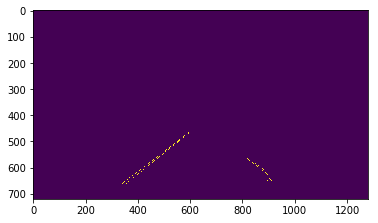

[275, 720, 640, 432]
[1016, 720, 649, 432]


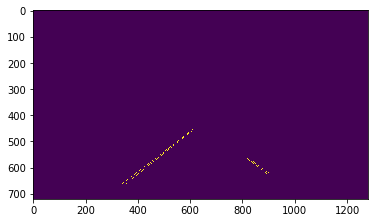

[277, 720, 639, 432]
[1022, 720, 641, 432]


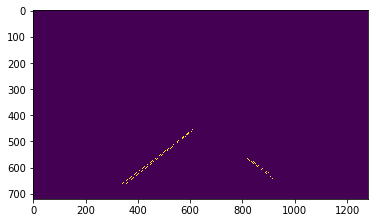

[277, 720, 639, 432]
[1019, 720, 641, 432]


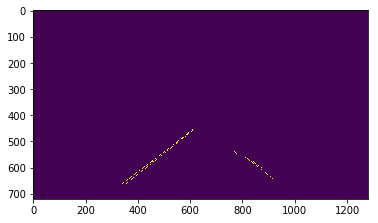

[277, 720, 640, 432]
[1021, 720, 640, 432]


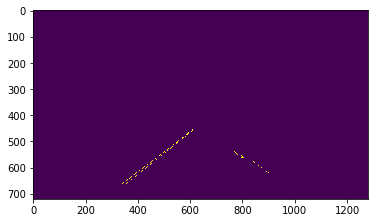

[273, 720, 640, 432]
[273, 720, 640, 432]


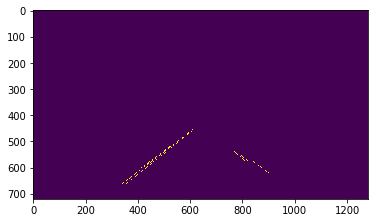

[268, 720, 641, 432]
[268, 720, 641, 432]


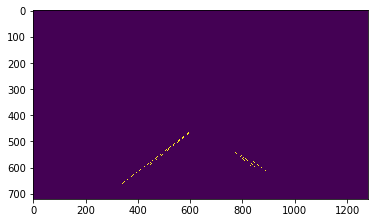

[267, 720, 642, 432]
[977, 720, 648, 432]


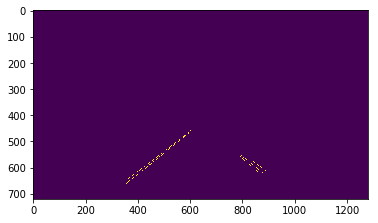

[272, 720, 639, 432]
[987, 720, 648, 432]


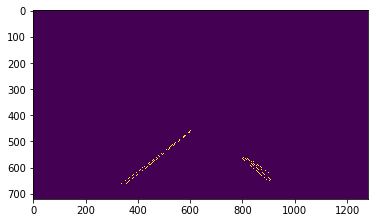

[273, 720, 641, 432]
[1004, 720, 643, 432]


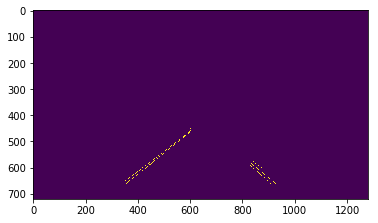

[269, 720, 641, 432]
[988, 720, 645, 432]


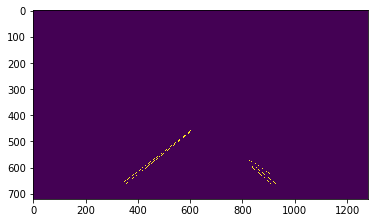

[272, 720, 639, 432]
[987, 720, 646, 432]


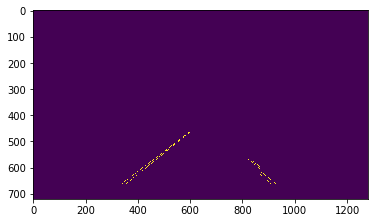

[272, 720, 640, 432]
[272, 720, 640, 432]


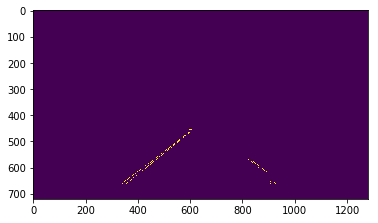

[266, 720, 641, 432]
[266, 720, 641, 432]


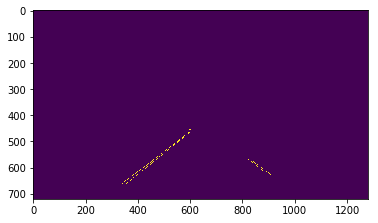

[269, 720, 641, 432]
[1014, 720, 649, 432]


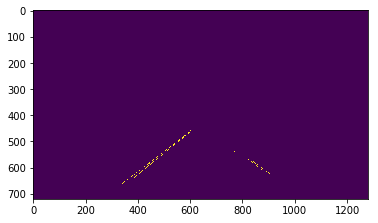

[270, 720, 639, 432]
[1033, 720, 645, 432]


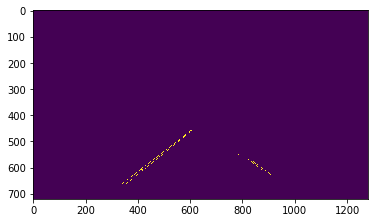

[270, 720, 637, 432]
[1032, 720, 648, 432]


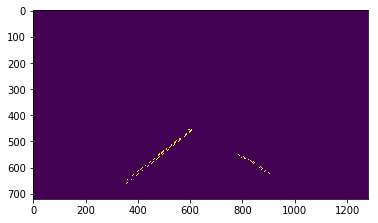

[269, 720, 638, 432]
[1038, 720, 642, 432]


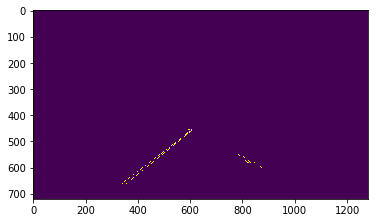

[269, 720, 638, 432]
[269, 720, 638, 432]


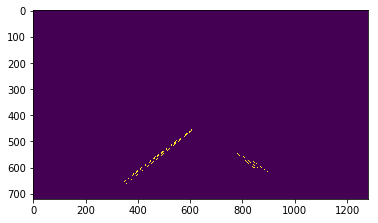

[268, 720, 636, 432]
[978, 720, 650, 432]


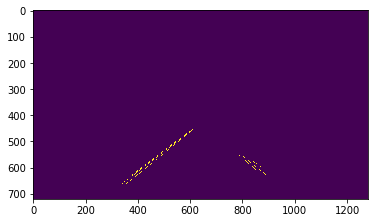

[266, 720, 638, 432]
[992, 720, 647, 432]


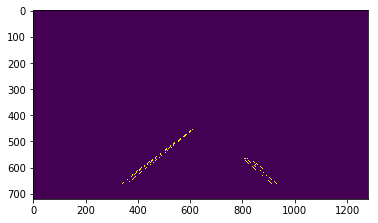

[272, 720, 636, 432]
[991, 720, 647, 432]


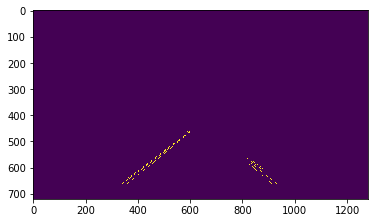

[274, 720, 640, 432]
[989, 720, 652, 432]


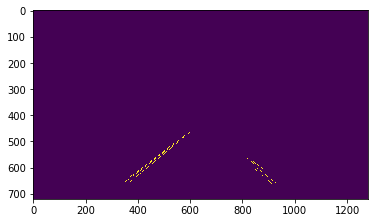

[276, 720, 638, 432]
[1003, 720, 645, 432]


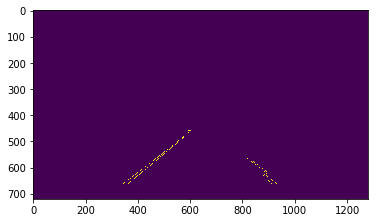

[282, 720, 637, 432]
[282, 720, 637, 432]


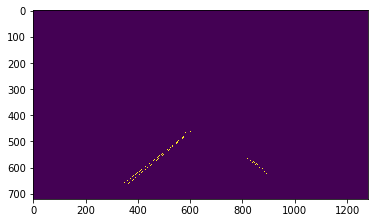

[282, 720, 639, 432]
[1017, 720, 650, 432]


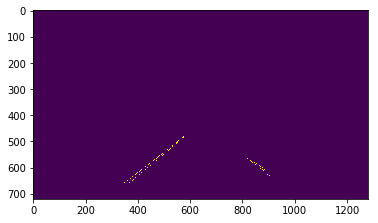

[286, 720, 639, 432]
[1023, 720, 641, 432]


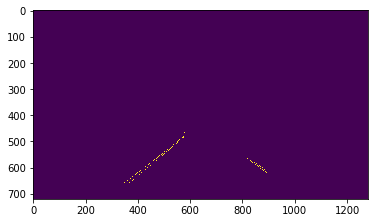

[287, 720, 638, 432]
[1023, 720, 645, 432]


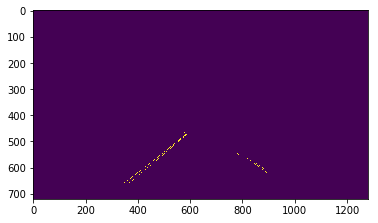

[287, 720, 638, 432]
[1025, 720, 642, 432]


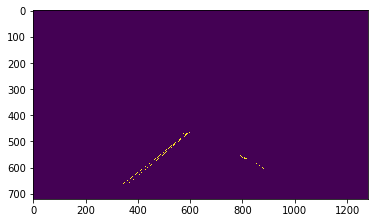

[283, 720, 638, 432]
[283, 720, 638, 432]


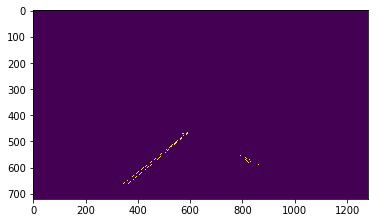

[280, 720, 636, 432]
[280, 720, 636, 432]


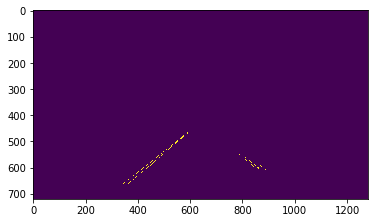

[282, 720, 634, 432]
[996, 720, 641, 432]


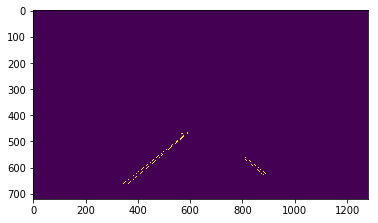

[279, 720, 636, 432]
[992, 720, 646, 432]


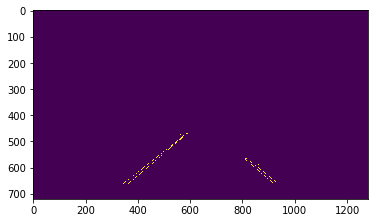

[288, 720, 634, 432]
[1002, 720, 646, 432]


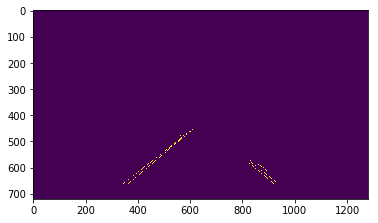

[281, 720, 635, 432]
[998, 720, 649, 432]


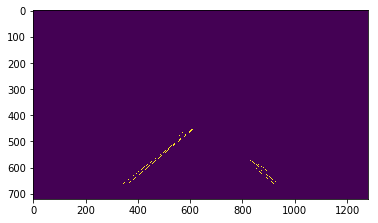

[277, 720, 636, 432]
[1002, 720, 641, 432]


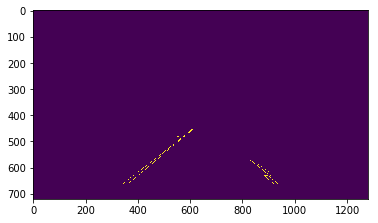

[282, 720, 635, 432]
[282, 720, 635, 432]


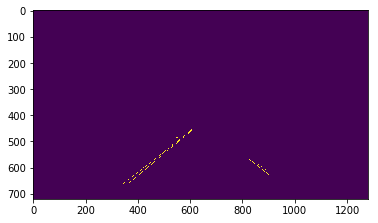

[277, 720, 637, 432]
[1024, 720, 645, 432]


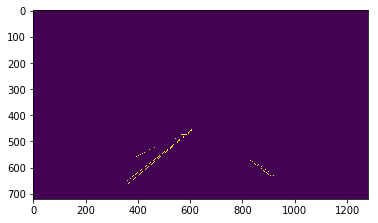

[247, 720, 636, 432]
[247, 720, 636, 432]


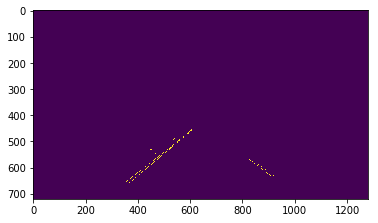

[284, 720, 637, 432]
[284, 720, 637, 432]


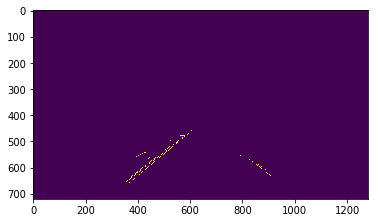

[282, 720, 636, 432]
[1022, 720, 650, 432]


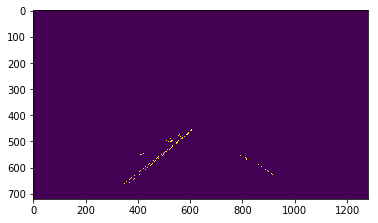

[285, 720, 638, 432]
[285, 720, 638, 432]


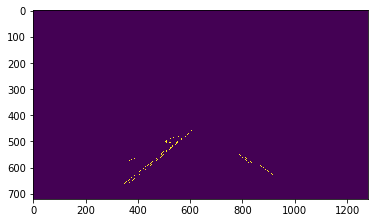

[281, 720, 641, 432]
[281, 720, 641, 432]


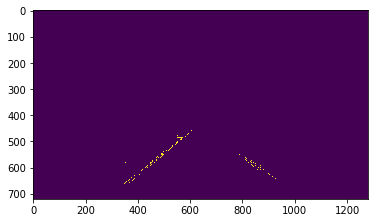

[282, 720, 641, 432]
[1012, 720, 644, 432]


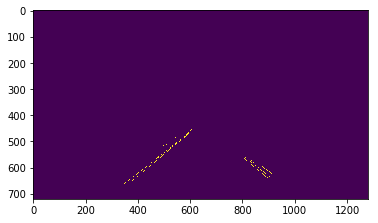

[284, 720, 639, 432]
[1001, 720, 647, 432]


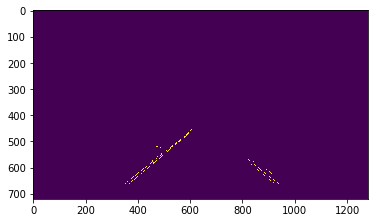

[279, 720, 638, 432]
[1000, 720, 649, 432]


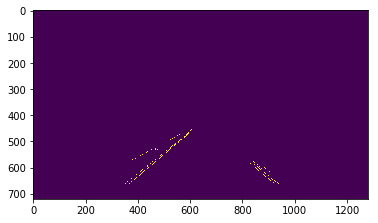

[272, 720, 638, 432]
[996, 720, 650, 432]


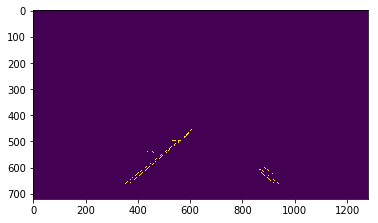

[291, 720, 639, 432]
[1001, 720, 652, 432]


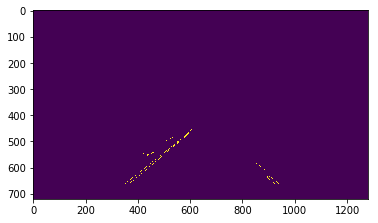

[288, 720, 642, 432]
[288, 720, 642, 432]


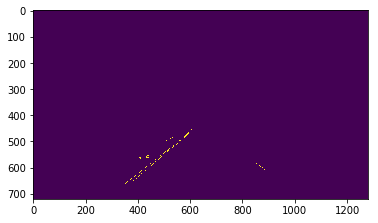

[295, 720, 639, 432]
[295, 720, 639, 432]


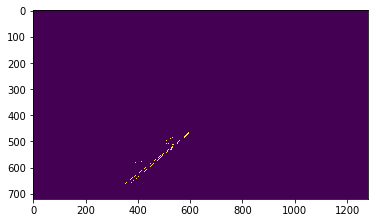

[294, 720, 638, 432]
[294, 720, 638, 432]


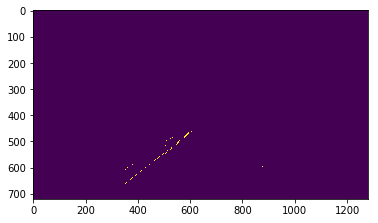

[293, 720, 639, 432]
[293, 720, 639, 432]


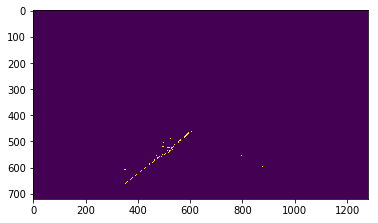

[289, 720, 641, 432]
[289, 720, 641, 432]


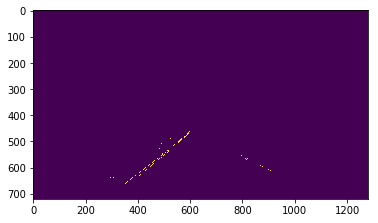

[286, 720, 643, 432]
[286, 720, 643, 432]


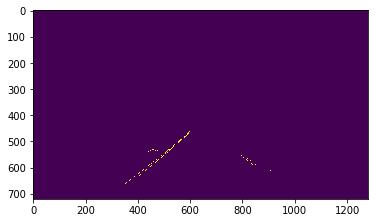

[298, 720, 640, 432]
[298, 720, 640, 432]


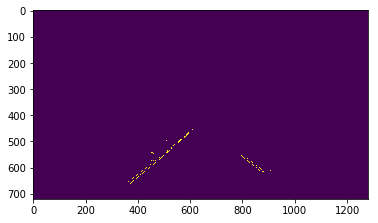

[297, 720, 641, 432]
[1000, 720, 644, 432]


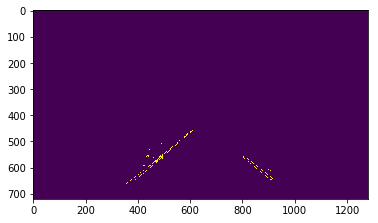

[300, 720, 638, 432]
[1009, 720, 641, 432]


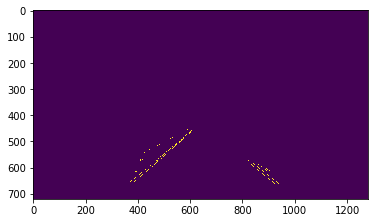

[303, 720, 639, 432]
[1003, 720, 647, 432]


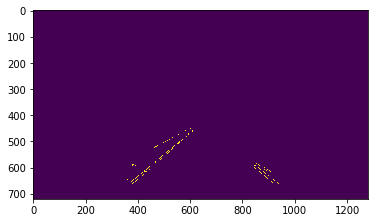

[279, 720, 640, 432]
[1002, 720, 644, 432]


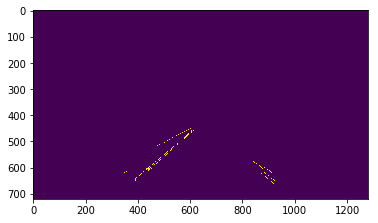

[291, 720, 639, 432]
[291, 720, 639, 432]


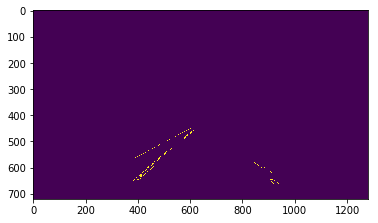

[256, 720, 640, 432]
[256, 720, 640, 432]


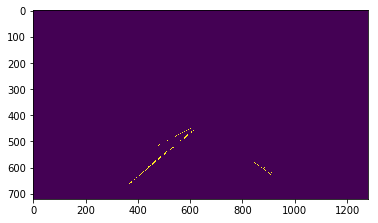

[274, 720, 643, 432]
[274, 720, 643, 432]


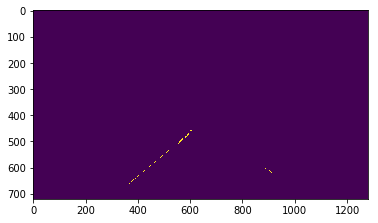

[298, 720, 640, 432]
[298, 720, 640, 432]


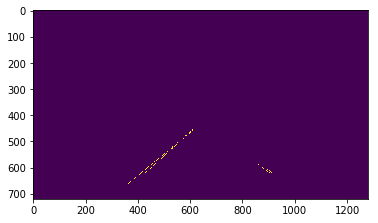

[303, 720, 638, 432]
[303, 720, 638, 432]


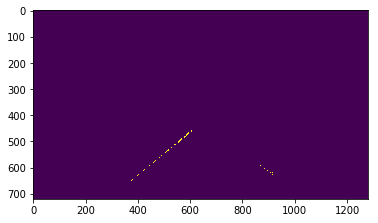

[289, 720, 641, 432]
[289, 720, 641, 432]


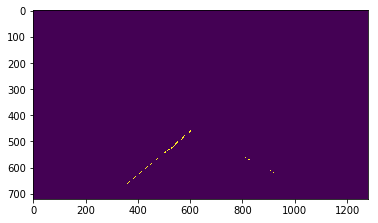

[291, 720, 635, 432]
[291, 720, 635, 432]


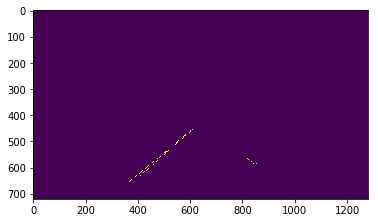

[294, 720, 634, 432]
[294, 720, 634, 432]


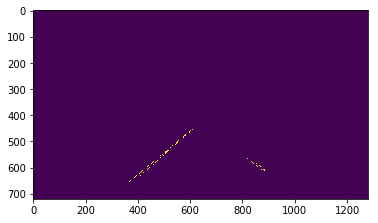

[298, 720, 634, 432]
[298, 720, 634, 432]


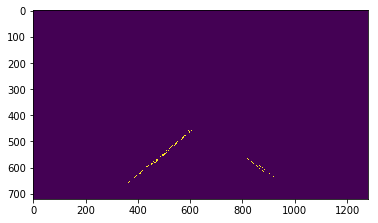

[299, 720, 633, 432]
[1022, 720, 654, 432]


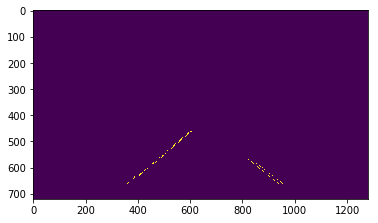

[296, 720, 637, 432]
[1020, 720, 654, 432]


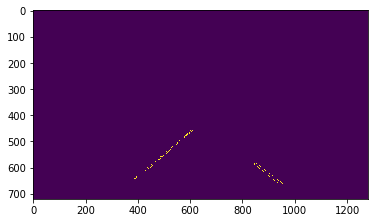

[306, 720, 637, 432]
[1019, 720, 658, 432]


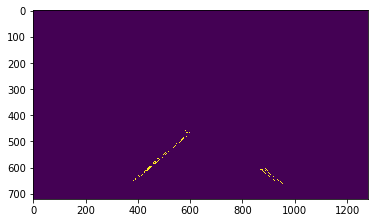

[304, 720, 640, 432]
[1019, 720, 653, 432]


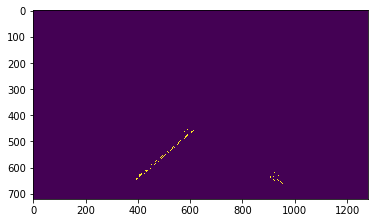

[305, 720, 638, 432]
[305, 720, 638, 432]


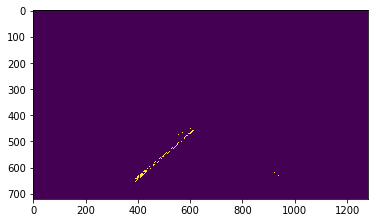

[302, 720, 641, 432]
[302, 720, 641, 432]


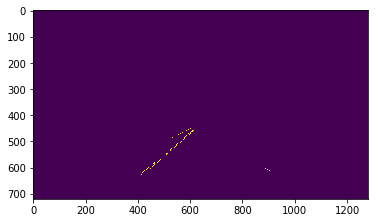

[310, 720, 641, 432]
[310, 720, 641, 432]


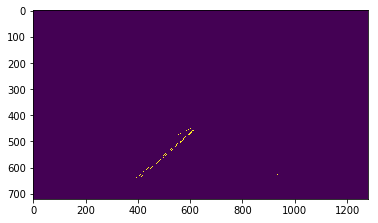

[305, 720, 643, 432]
[305, 720, 643, 432]


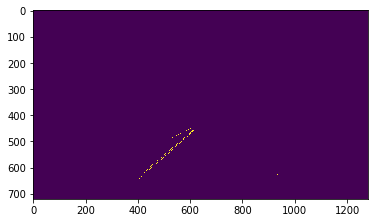

[309, 720, 643, 432]
[309, 720, 643, 432]


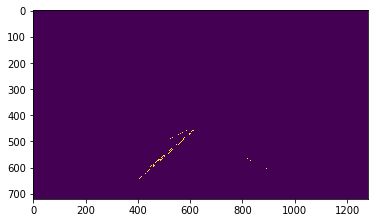

[308, 720, 645, 432]
[308, 720, 645, 432]


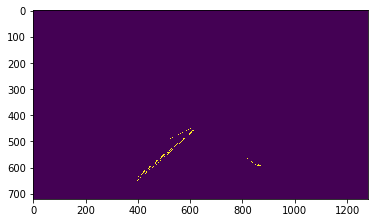

[309, 720, 643, 432]
[309, 720, 643, 432]


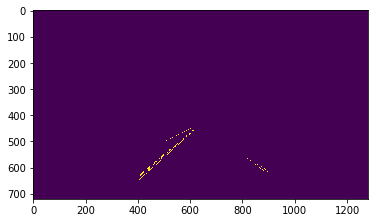

[306, 720, 643, 432]
[1022, 720, 645, 432]


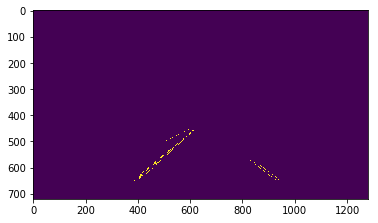

[307, 720, 642, 432]
[1031, 720, 649, 432]


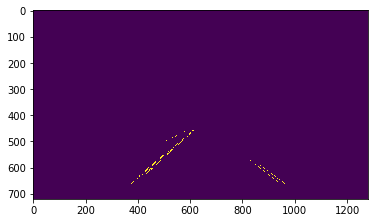

[310, 720, 642, 432]
[1027, 720, 649, 432]


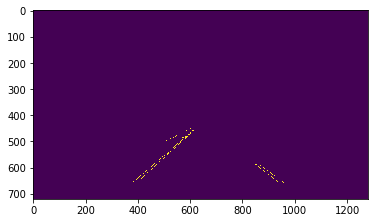

[287, 720, 641, 432]
[1028, 720, 649, 432]


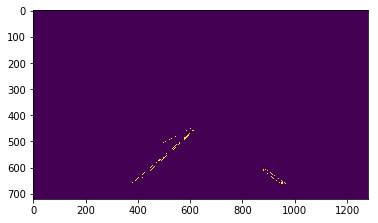

[289, 720, 641, 432]
[1047, 720, 646, 432]


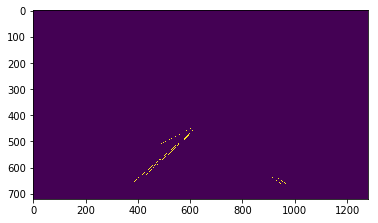

[301, 720, 640, 432]
[301, 720, 640, 432]


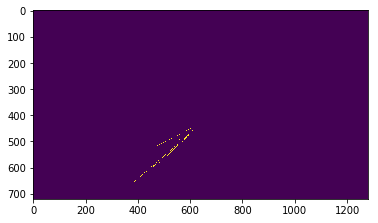

[285, 720, 643, 432]
[285, 720, 643, 432]


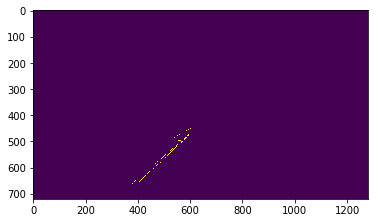

[331, 720, 641, 432]
[331, 720, 641, 432]


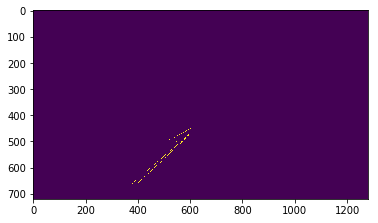

[322, 720, 645, 432]
[322, 720, 645, 432]


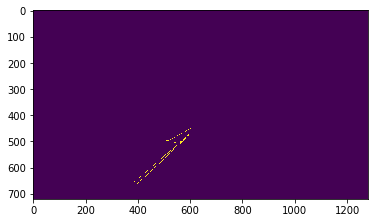

[312, 720, 640, 432]
[312, 720, 640, 432]


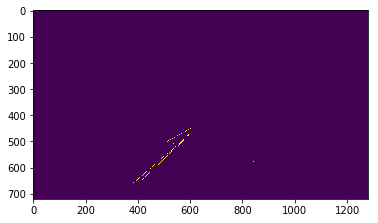

[301, 720, 643, 432]
[301, 720, 643, 432]


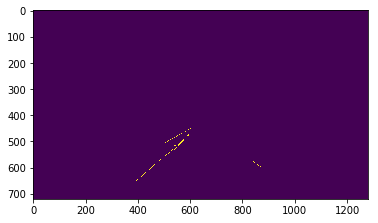

[283, 720, 644, 432]
[283, 720, 644, 432]


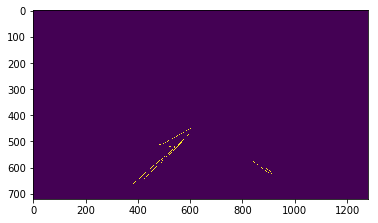

[303, 720, 642, 432]
[1032, 720, 646, 432]


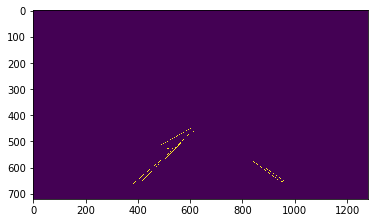

[306, 720, 644, 432]
[1038, 720, 642, 432]


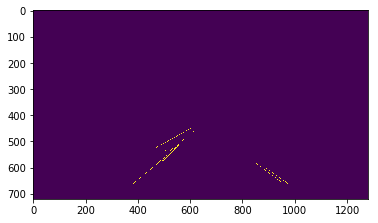

[291, 720, 644, 432]
[1045, 720, 643, 432]


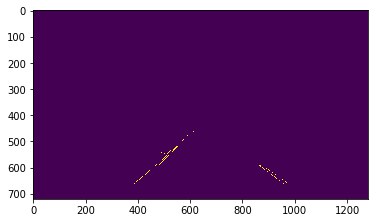

[336, 720, 643, 432]
[1046, 720, 651, 432]


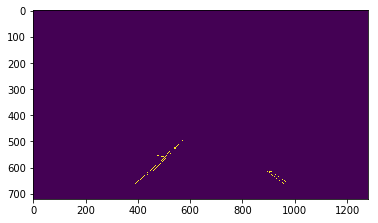

[329, 720, 644, 432]
[1036, 720, 650, 432]


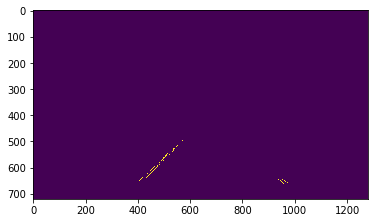

[341, 720, 641, 432]
[341, 720, 641, 432]


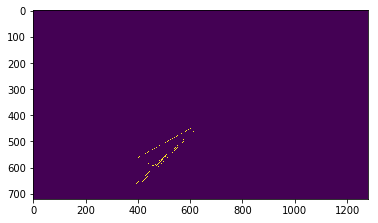

[315, 720, 641, 432]
[315, 720, 641, 432]


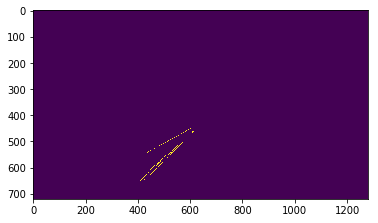

[286, 720, 640, 432]
[286, 720, 640, 432]


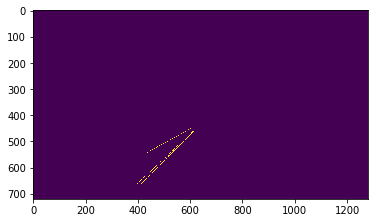

[311, 720, 640, 432]
[311, 720, 640, 432]


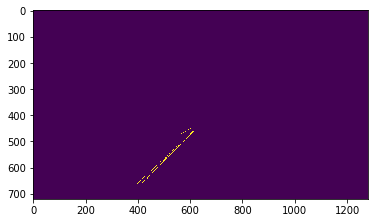

[347, 720, 642, 432]
[347, 720, 642, 432]


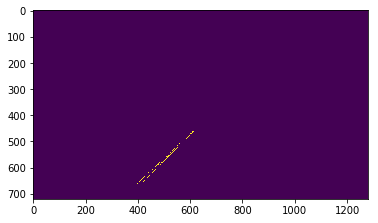

[343, 720, 642, 432]
[343, 720, 642, 432]


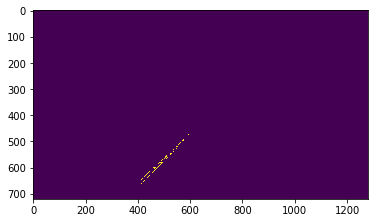

[342, 720, 639, 432]
[342, 720, 639, 432]


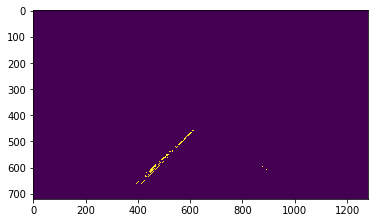

[340, 720, 638, 432]
[340, 720, 638, 432]


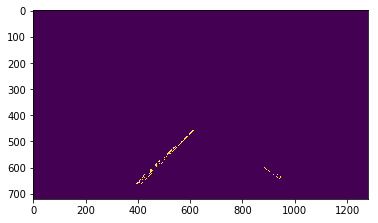

[339, 720, 638, 432]
[1049, 720, 651, 432]


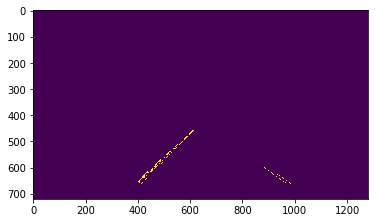

[339, 720, 636, 432]
[1049, 720, 653, 432]


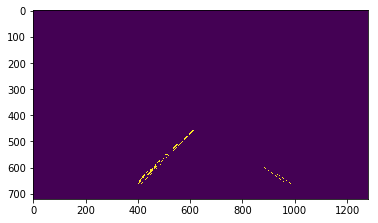

[340, 720, 635, 432]
[1048, 720, 651, 432]


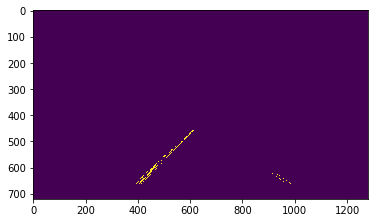

[341, 720, 639, 432]
[1047, 720, 655, 432]


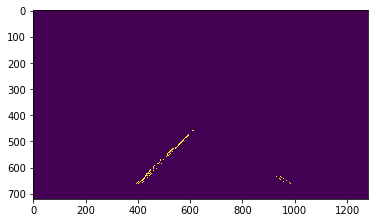

[341, 720, 635, 432]
[341, 720, 635, 432]


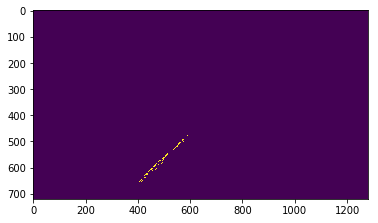

[337, 720, 639, 432]
[337, 720, 639, 432]


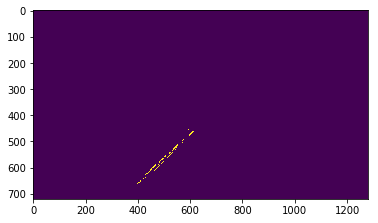

[333, 720, 641, 432]
[333, 720, 641, 432]


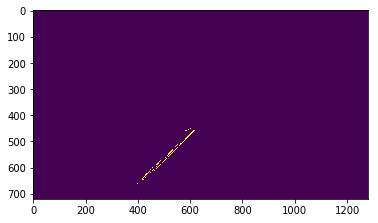

[336, 720, 640, 432]
[336, 720, 640, 432]


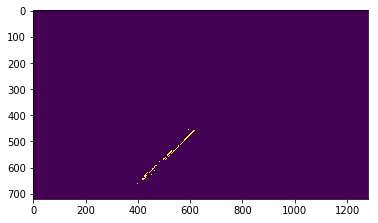

[342, 720, 642, 432]
[342, 720, 642, 432]


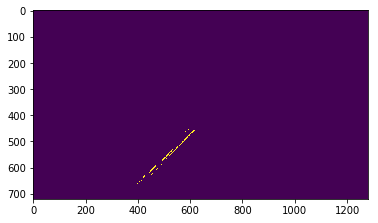

[339, 720, 643, 432]
[339, 720, 643, 432]


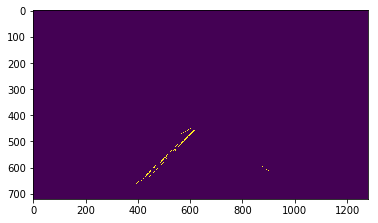

[342, 720, 641, 432]
[342, 720, 641, 432]


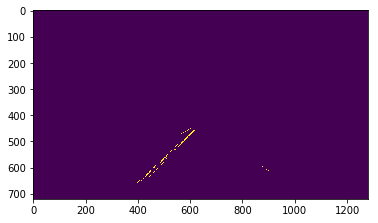

[339, 720, 641, 432]
[339, 720, 641, 432]


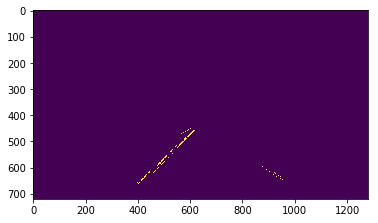

[344, 720, 639, 432]
[1054, 720, 641, 432]


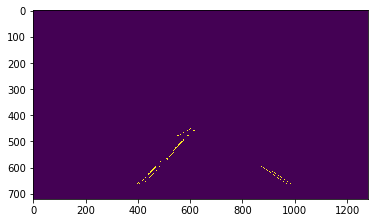

[350, 720, 641, 432]
[1062, 720, 640, 432]


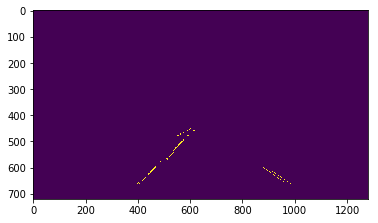

[349, 720, 639, 432]
[1061, 720, 638, 432]


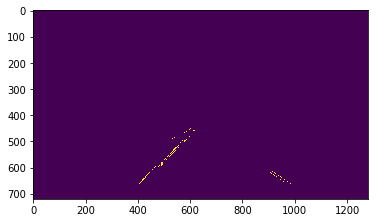

[352, 720, 641, 432]
[352, 720, 641, 432]


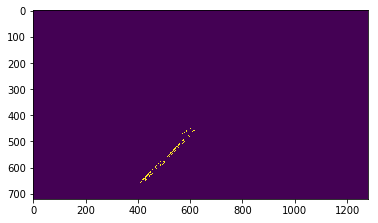

[347, 720, 642, 432]
[347, 720, 642, 432]


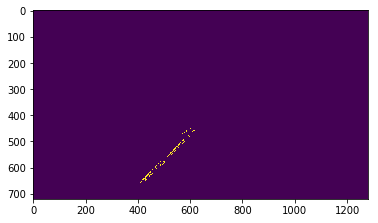

[346, 720, 641, 432]
[346, 720, 641, 432]


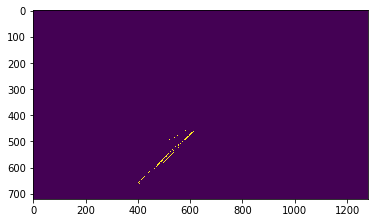

[351, 720, 638, 432]
[351, 720, 638, 432]


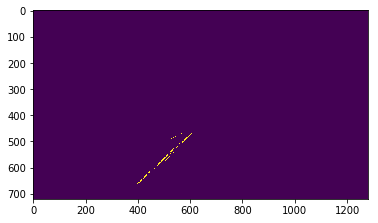

[347, 720, 640, 432]
[347, 720, 640, 432]


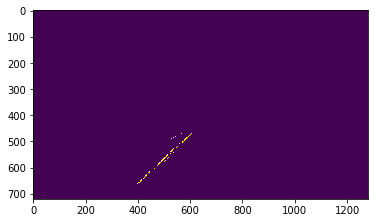

[347, 720, 638, 432]
[347, 720, 638, 432]


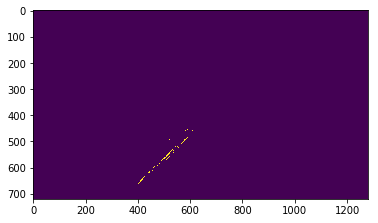

[347, 720, 638, 432]
[347, 720, 638, 432]


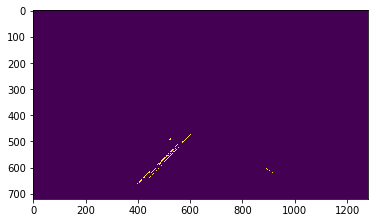

[346, 720, 642, 432]
[346, 720, 642, 432]


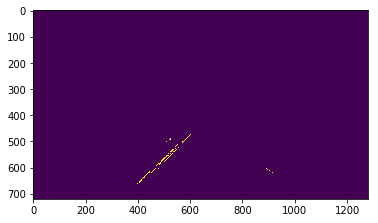

[348, 720, 640, 432]
[348, 720, 640, 432]


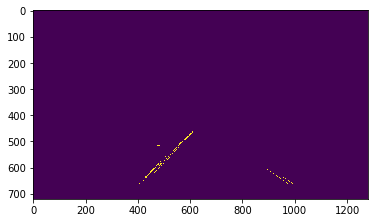

[346, 720, 639, 432]
[1054, 720, 653, 432]


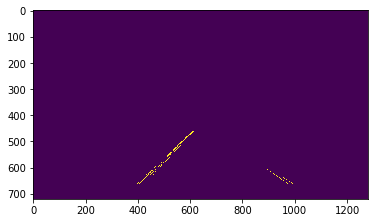

[350, 720, 640, 432]
[1054, 720, 652, 432]


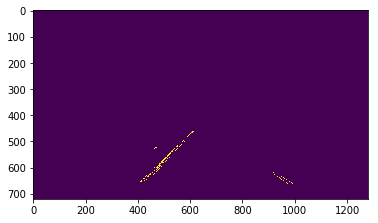

[349, 720, 641, 432]
[349, 720, 641, 432]


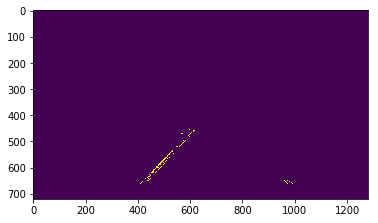

[355, 720, 640, 432]
[355, 720, 640, 432]


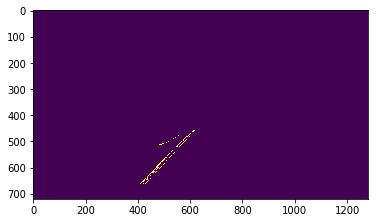

[359, 720, 640, 432]
[359, 720, 640, 432]


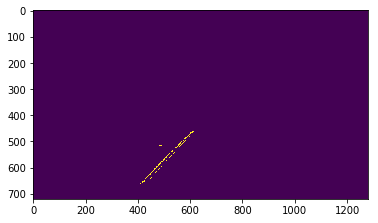

[359, 720, 638, 432]
[359, 720, 638, 432]


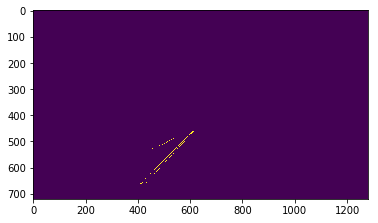

[360, 720, 640, 432]
[360, 720, 640, 432]


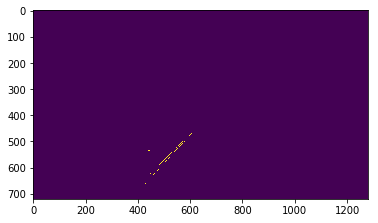

[362, 720, 639, 432]
[362, 720, 639, 432]


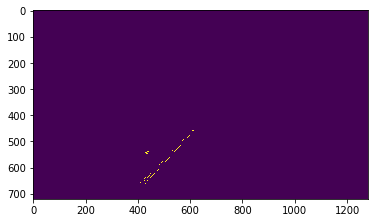

[364, 720, 638, 432]
[364, 720, 638, 432]


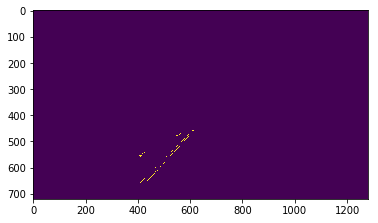

[358, 720, 640, 432]
[358, 720, 640, 432]


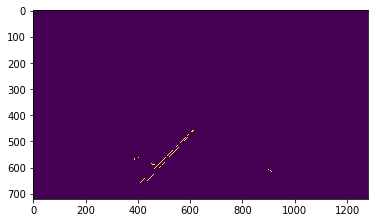

[355, 720, 636, 432]
[355, 720, 636, 432]


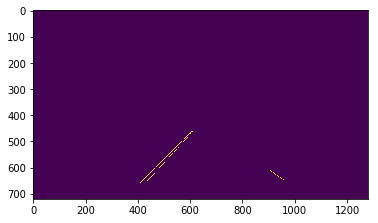

[355, 720, 636, 432]
[355, 720, 636, 432]


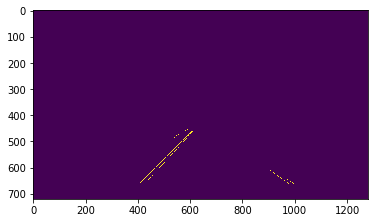

[355, 720, 636, 432]
[1064, 720, 643, 432]


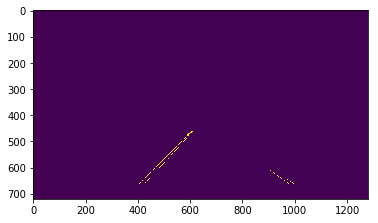

[354, 720, 635, 432]
[1064, 720, 643, 432]


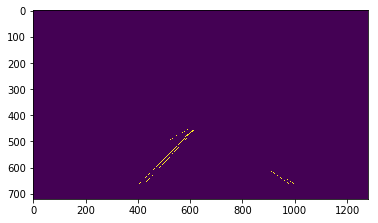

[363, 720, 637, 432]
[1065, 720, 641, 432]


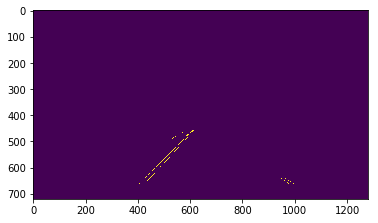

[357, 720, 638, 432]
[357, 720, 638, 432]


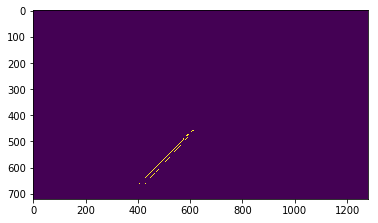

[359, 720, 639, 432]
[359, 720, 639, 432]


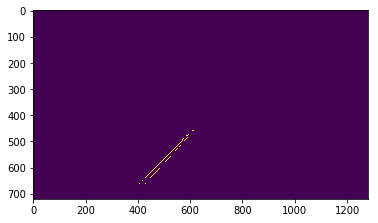

[356, 720, 639, 432]
[356, 720, 639, 432]


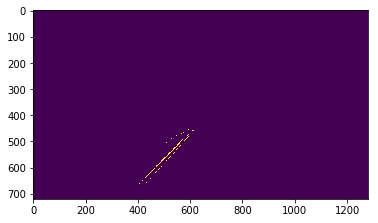

[354, 720, 638, 432]
[354, 720, 638, 432]


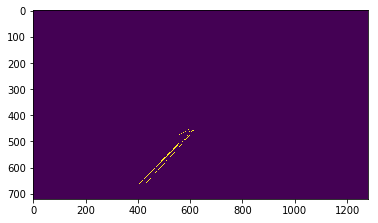

[349, 720, 639, 432]
[349, 720, 639, 432]


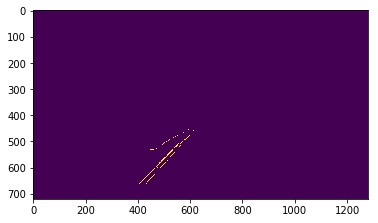

[357, 720, 637, 432]
[357, 720, 637, 432]


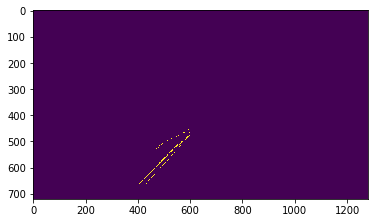

[357, 720, 638, 432]
[357, 720, 638, 432]


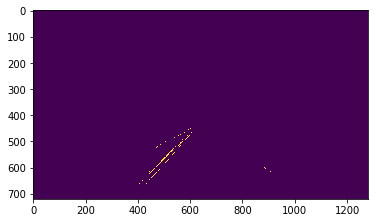

[335, 720, 638, 432]
[335, 720, 638, 432]


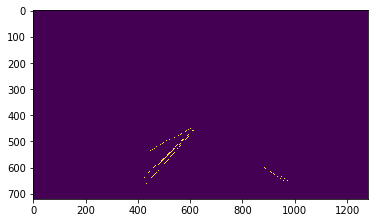

[360, 720, 639, 432]
[1055, 720, 645, 432]


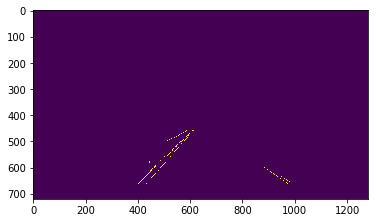

[353, 720, 637, 432]
[1057, 720, 644, 432]


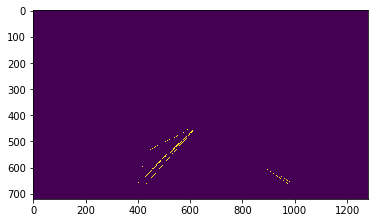

[329, 720, 636, 432]
[1054, 720, 655, 432]


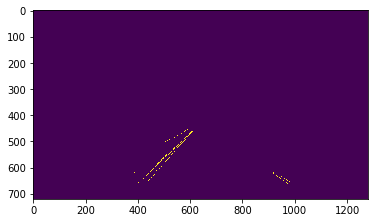

[356, 720, 635, 432]
[356, 720, 635, 432]


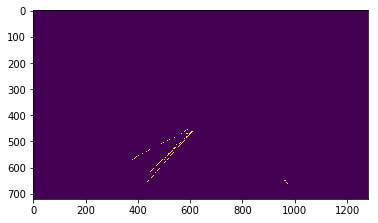

[324, 720, 635, 432]
[324, 720, 635, 432]


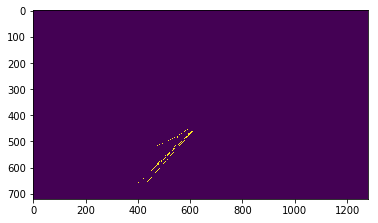

[355, 720, 635, 432]
[355, 720, 635, 432]


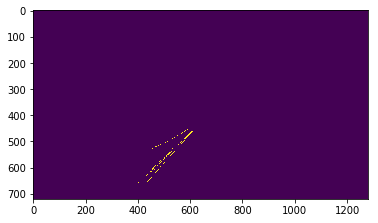

[320, 720, 637, 432]
[320, 720, 637, 432]


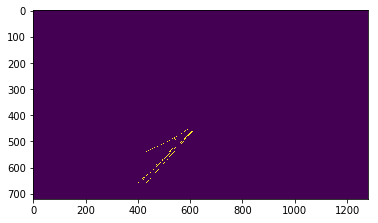

[317, 720, 635, 432]
[317, 720, 635, 432]


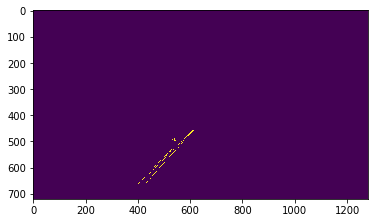

[350, 720, 633, 432]
[350, 720, 633, 432]


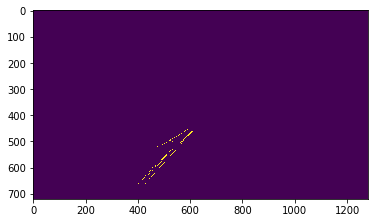

[331, 720, 634, 432]
[331, 720, 634, 432]


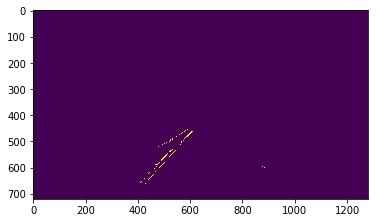

[346, 720, 635, 432]
[346, 720, 635, 432]


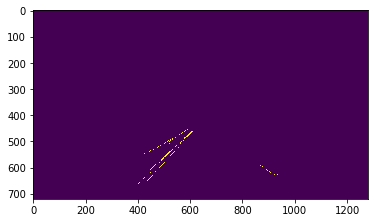

[327, 720, 635, 432]
[327, 720, 635, 432]


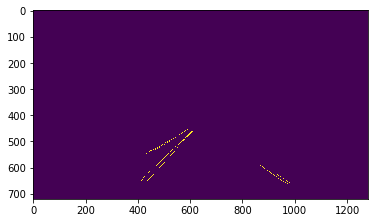

[313, 720, 636, 432]
[1051, 720, 642, 432]


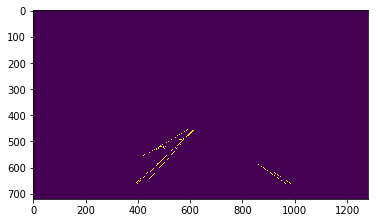

[336, 720, 638, 432]
[1054, 720, 631, 432]


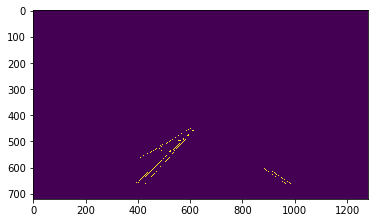

[296, 720, 638, 432]
[1062, 720, 633, 432]


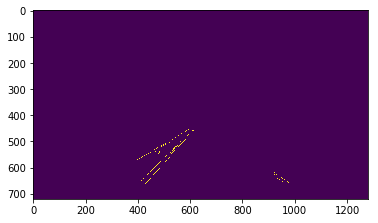

[325, 720, 637, 432]
[325, 720, 637, 432]


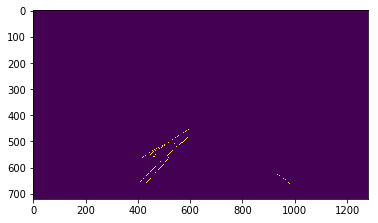

[323, 720, 636, 432]
[323, 720, 636, 432]


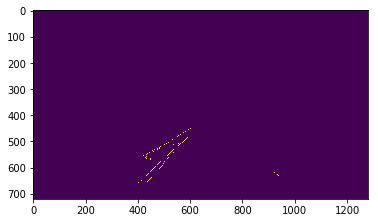

[335, 720, 635, 432]
[335, 720, 635, 432]


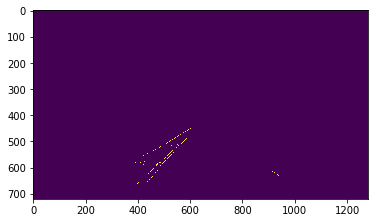

[308, 720, 639, 432]
[308, 720, 639, 432]


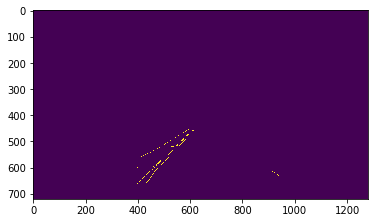

[308, 720, 640, 432]
[308, 720, 640, 432]


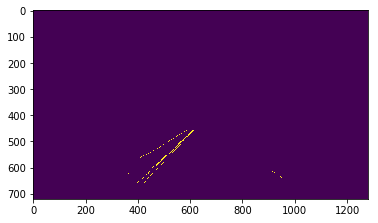

[331, 720, 637, 432]
[331, 720, 637, 432]


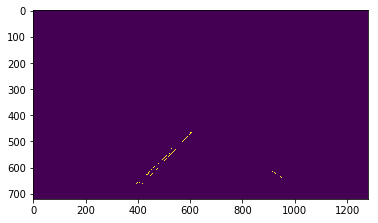

[345, 720, 638, 432]
[345, 720, 638, 432]


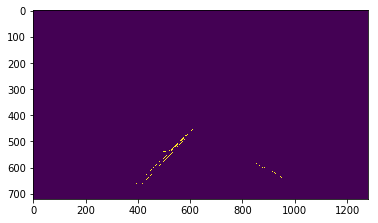

[347, 720, 636, 432]
[347, 720, 636, 432]


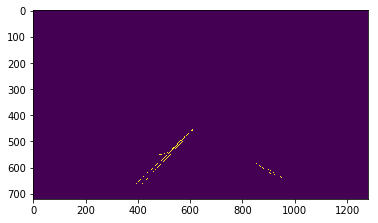

[345, 720, 635, 432]
[345, 720, 635, 432]


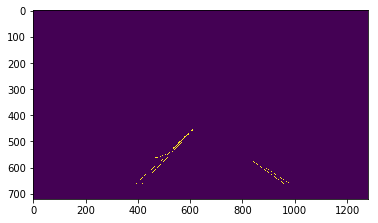

[342, 720, 636, 432]
[1054, 720, 634, 432]


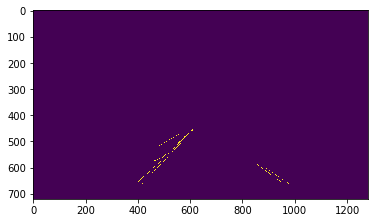

[323, 720, 634, 432]
[1050, 720, 643, 432]


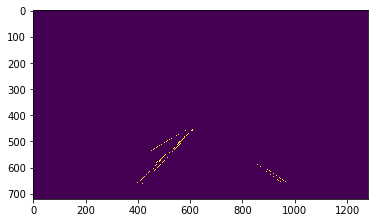

[320, 720, 632, 432]
[1048, 720, 642, 432]


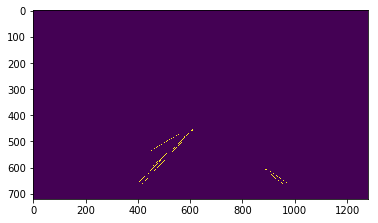

[326, 720, 631, 432]
[1066, 720, 623, 432]


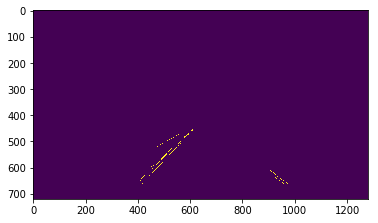

[329, 720, 630, 432]
[329, 720, 630, 432]


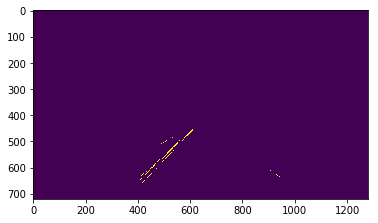

[336, 720, 633, 432]
[336, 720, 633, 432]


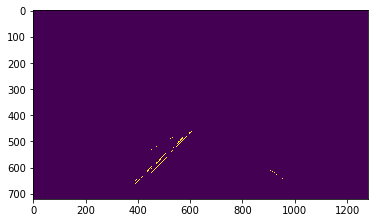

[340, 720, 632, 432]
[340, 720, 632, 432]


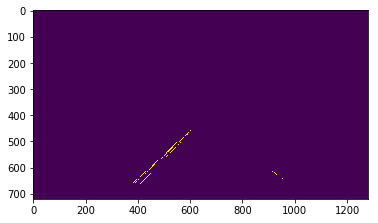

[327, 720, 628, 432]
[327, 720, 628, 432]


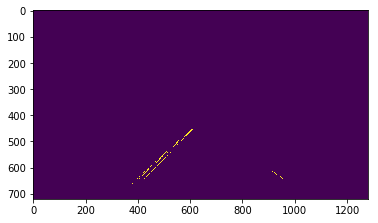

[331, 720, 628, 432]
[331, 720, 628, 432]


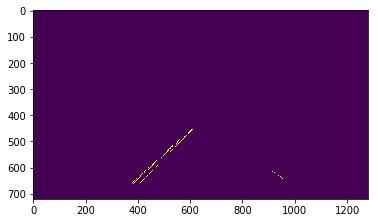

[326, 720, 629, 432]
[326, 720, 629, 432]


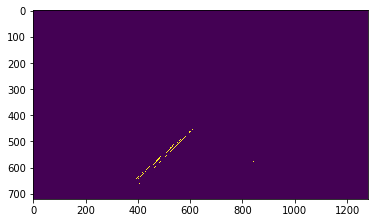

[322, 720, 630, 432]
[322, 720, 630, 432]


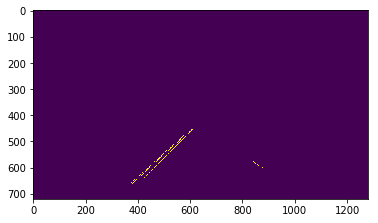

[319, 720, 629, 432]
[319, 720, 629, 432]


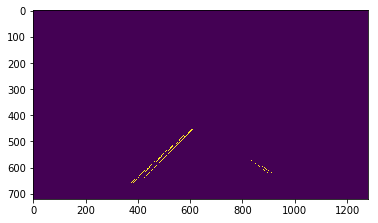

[323, 720, 629, 432]
[1037, 720, 637, 432]


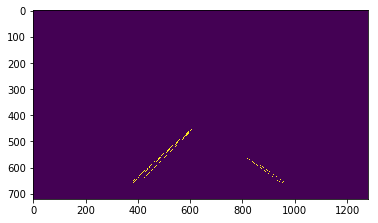

[317, 720, 629, 432]
[1040, 720, 641, 432]


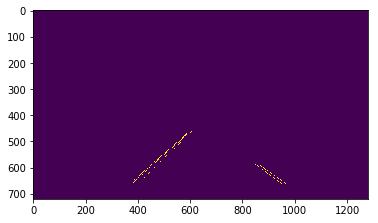

[317, 720, 632, 432]
[1035, 720, 639, 432]


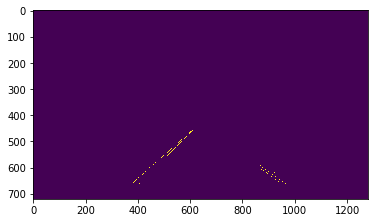

[328, 720, 634, 432]
[1037, 720, 637, 432]


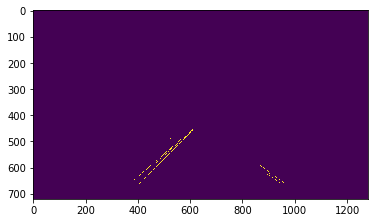

[333, 720, 634, 432]
[1049, 720, 633, 432]


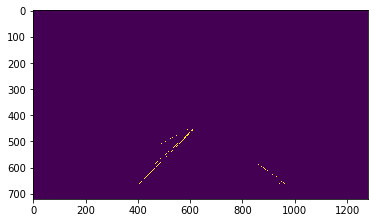

[333, 720, 637, 432]
[1051, 720, 636, 432]


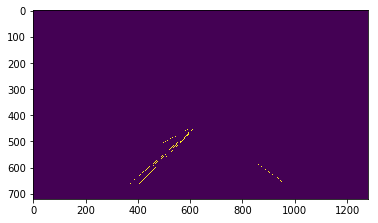

[329, 720, 634, 432]
[1047, 720, 640, 432]


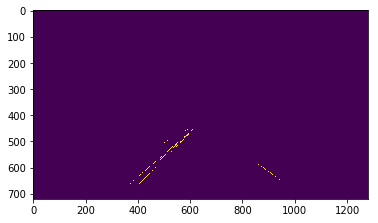

[326, 720, 635, 432]
[1048, 720, 640, 432]


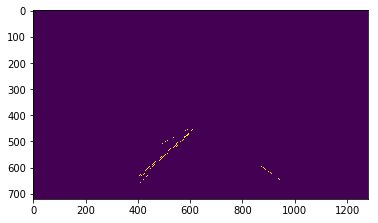

[317, 720, 634, 432]
[1044, 720, 648, 432]


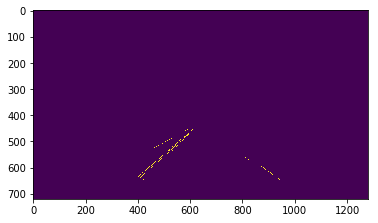

[311, 720, 635, 432]
[1048, 720, 641, 432]


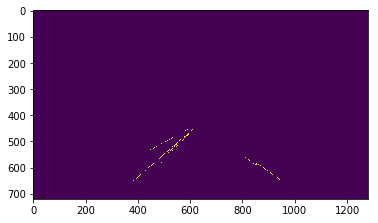

[310, 720, 636, 432]
[1047, 720, 644, 432]


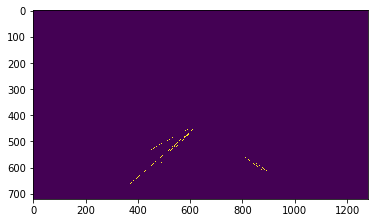

[312, 720, 635, 432]
[1023, 720, 639, 432]


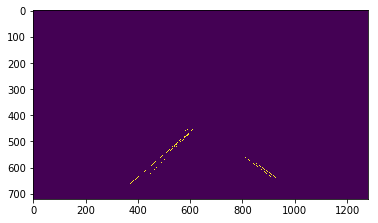

[329, 720, 635, 432]
[1032, 720, 639, 432]


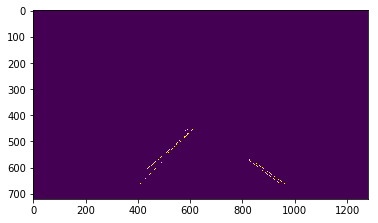

[323, 720, 635, 432]
[1029, 720, 639, 432]


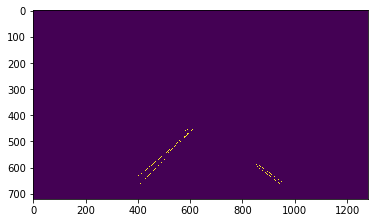

[334, 720, 635, 432]
[1036, 720, 637, 432]


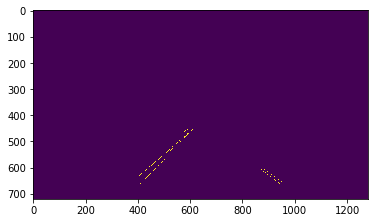

[321, 720, 635, 432]
[1034, 720, 631, 432]


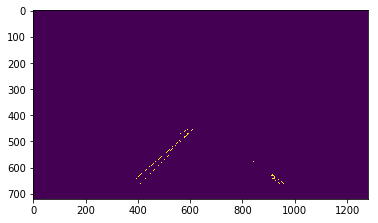

[320, 720, 636, 432]
[320, 720, 636, 432]


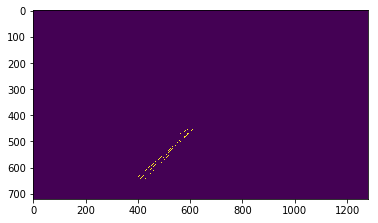

[327, 720, 635, 432]
[327, 720, 635, 432]


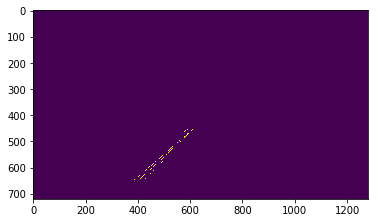

[327, 720, 635, 432]
[327, 720, 635, 432]


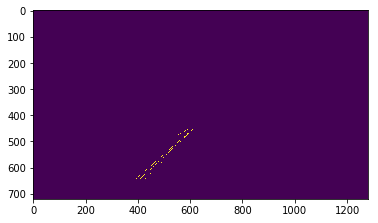

[325, 720, 637, 432]
[325, 720, 637, 432]


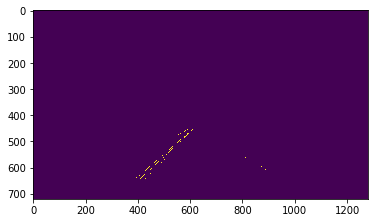

[324, 720, 635, 432]
[324, 720, 635, 432]


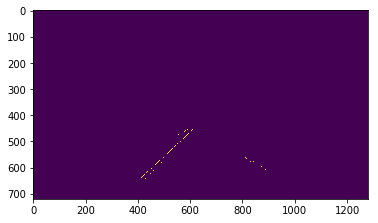

[338, 720, 635, 432]
[338, 720, 635, 432]


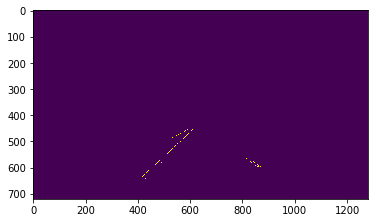

[333, 720, 634, 432]
[333, 720, 634, 432]


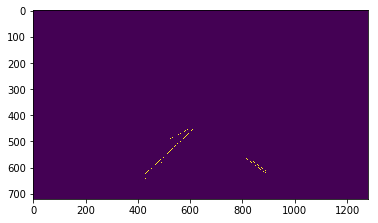

[337, 720, 635, 432]
[1040, 720, 637, 432]


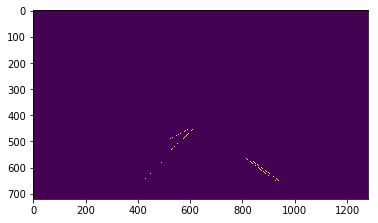

[340, 720, 634, 432]
[1026, 720, 642, 432]


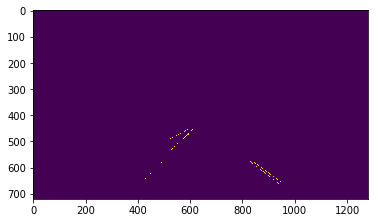

[341, 720, 634, 432]
[1022, 720, 640, 432]


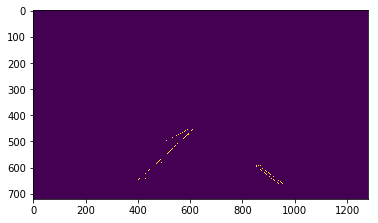

[308, 720, 635, 432]
[1023, 720, 647, 432]


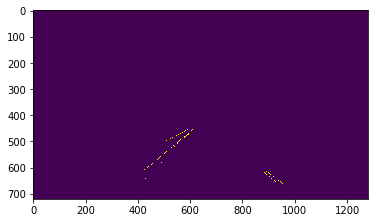

[288, 720, 635, 432]
[1022, 720, 647, 432]


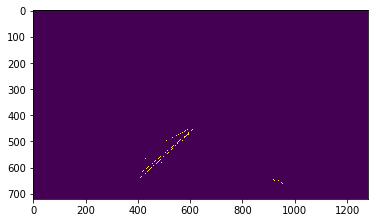

[305, 720, 636, 432]
[305, 720, 636, 432]


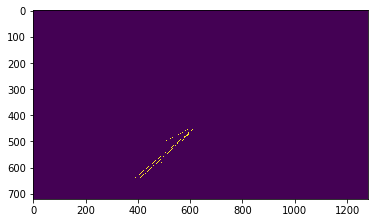

[301, 720, 635, 432]
[301, 720, 635, 432]


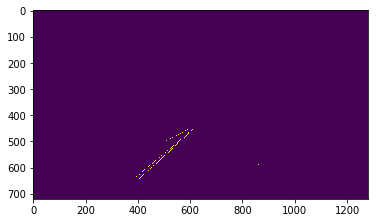

[286, 720, 636, 432]
[286, 720, 636, 432]


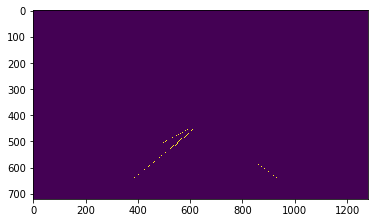

[266, 720, 635, 432]
[266, 720, 635, 432]


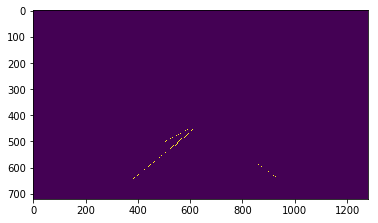

[240, 720, 637, 432]
[240, 720, 637, 432]


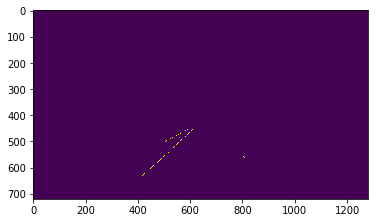

[236, 720, 634, 432]
[236, 720, 634, 432]


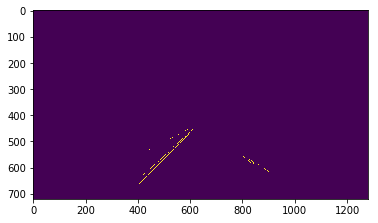

[340, 720, 634, 432]
[340, 720, 634, 432]


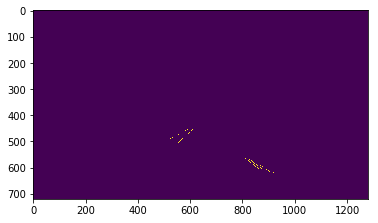

[314, 720, 634, 432]
[1005, 720, 647, 432]


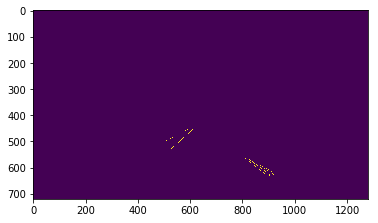

[314, 720, 634, 432]
[1016, 720, 645, 432]


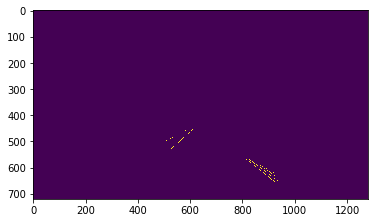

[306, 720, 636, 432]
[1017, 720, 643, 432]


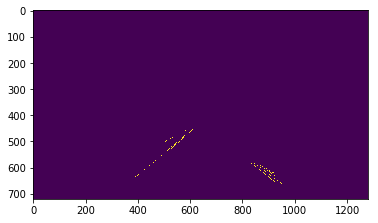

[297, 720, 635, 432]
[1019, 720, 637, 432]


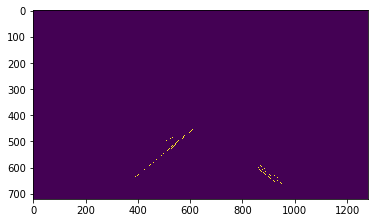

[297, 720, 636, 432]
[1028, 720, 640, 432]


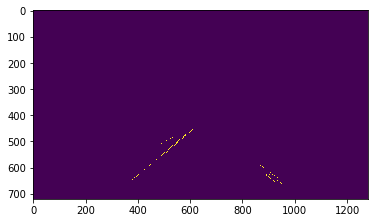

[290, 720, 637, 432]
[1047, 720, 647, 432]


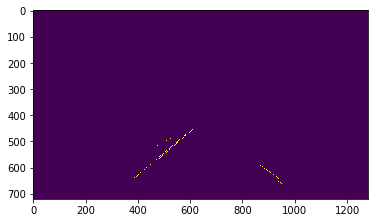

[294, 720, 635, 432]
[1048, 720, 645, 432]


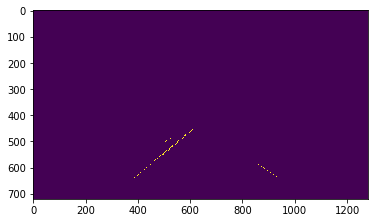

[290, 720, 637, 432]
[1057, 720, 630, 432]


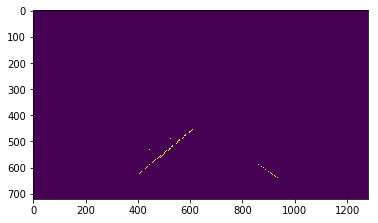

[294, 720, 633, 432]
[1051, 720, 636, 432]


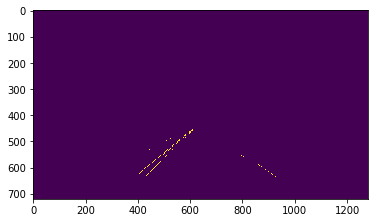

[303, 720, 636, 432]
[1048, 720, 640, 432]


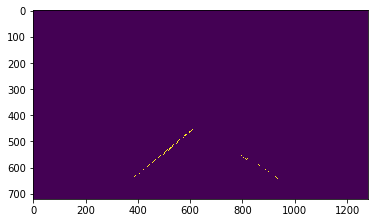

[287, 720, 635, 432]
[1047, 720, 641, 432]


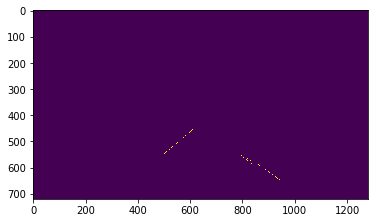

[304, 720, 634, 432]
[1048, 720, 636, 432]


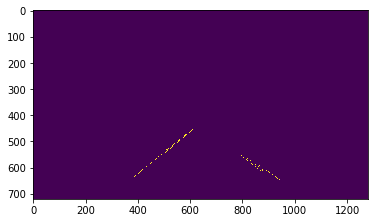

[282, 720, 637, 432]
[1037, 720, 639, 432]


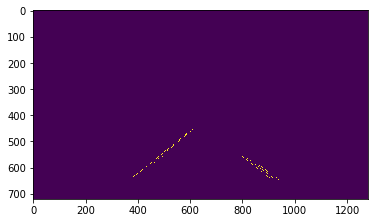

[283, 720, 635, 432]
[1024, 720, 642, 432]


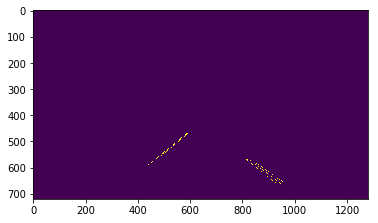

[289, 720, 633, 432]
[1025, 720, 640, 432]


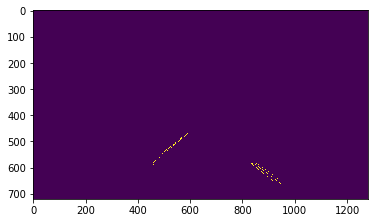

[289, 720, 633, 432]
[1025, 720, 640, 432]


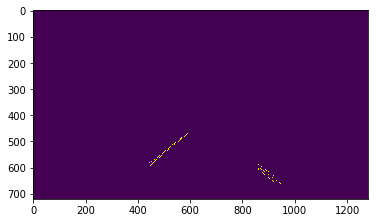

[286, 720, 632, 432]
[1013, 720, 638, 432]


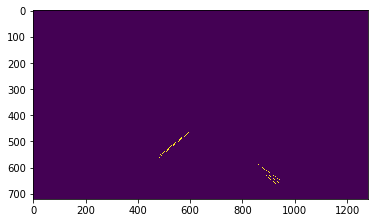

[288, 720, 633, 432]
[1043, 720, 643, 432]


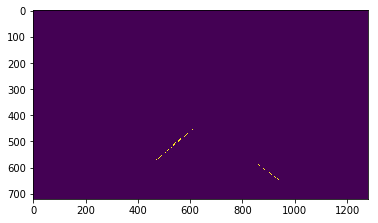

[294, 720, 635, 432]
[1040, 720, 645, 432]


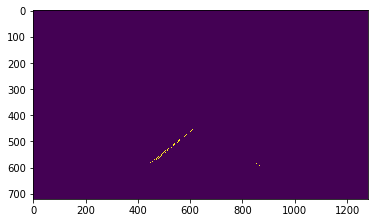

[288, 720, 633, 432]
[288, 720, 633, 432]


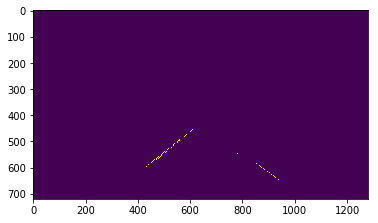

[286, 720, 635, 432]
[1036, 720, 652, 432]


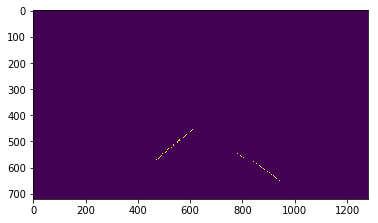

[285, 720, 637, 432]
[1044, 720, 636, 432]


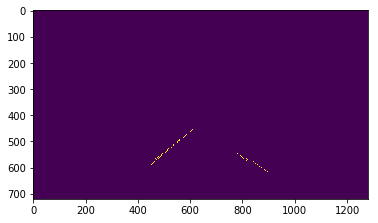

[286, 720, 635, 432]
[286, 720, 635, 432]


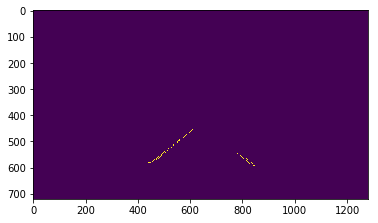

[282, 720, 637, 432]
[1002, 720, 635, 432]


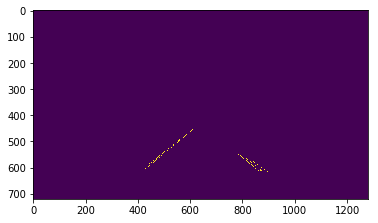

[286, 720, 636, 432]
[1007, 720, 639, 432]


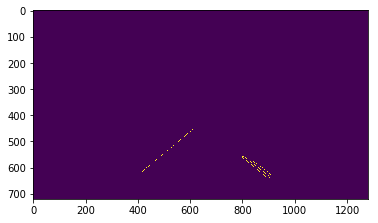

[293, 720, 636, 432]
[1007, 720, 639, 432]


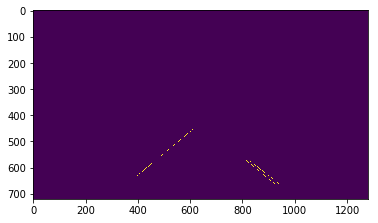

[294, 720, 632, 432]
[1002, 720, 647, 432]


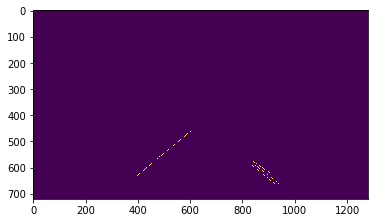

[286, 720, 637, 432]
[1003, 720, 646, 432]


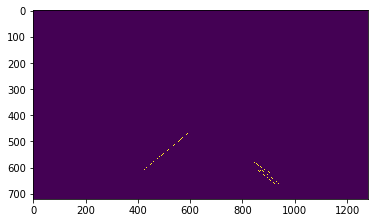

[285, 720, 638, 432]
[1018, 720, 640, 432]


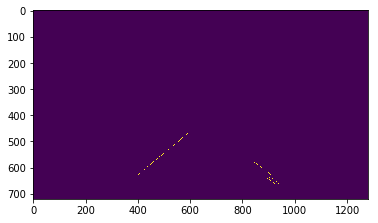

[286, 720, 637, 432]
[1037, 720, 643, 432]


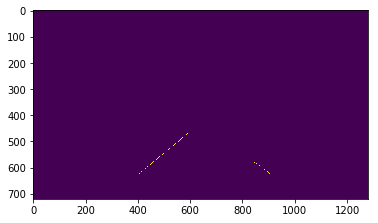

[285, 720, 638, 432]
[1029, 720, 658, 432]


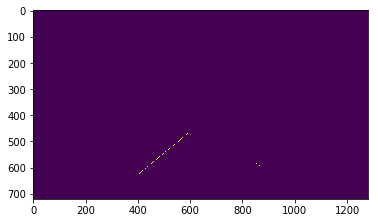

[284, 720, 638, 432]
[284, 720, 638, 432]


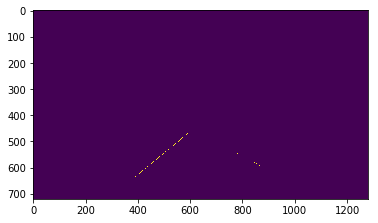

[285, 720, 638, 432]
[285, 720, 638, 432]


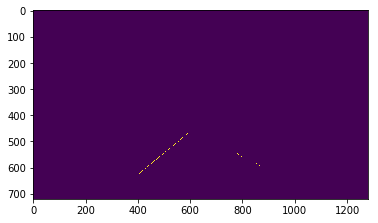

[286, 720, 635, 432]
[286, 720, 635, 432]


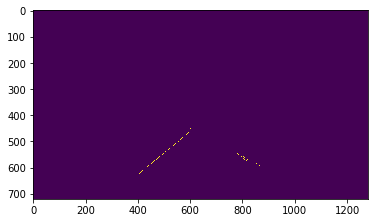

[284, 720, 637, 432]
[284, 720, 637, 432]


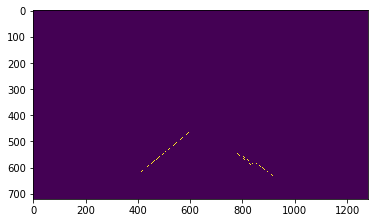

[286, 720, 637, 432]
[1035, 720, 652, 432]


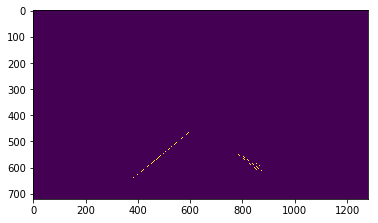

[285, 720, 636, 432]
[1004, 720, 638, 432]


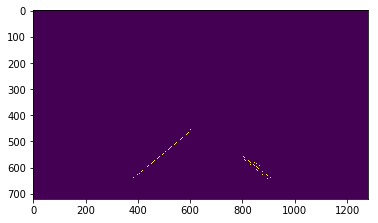

[285, 720, 635, 432]
[999, 720, 643, 432]


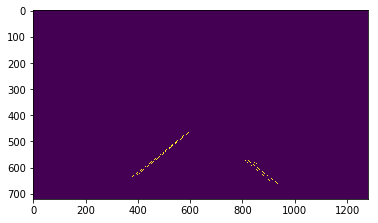

[278, 720, 634, 432]
[1004, 720, 637, 432]


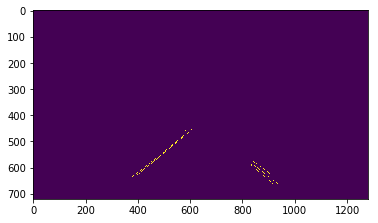

[280, 720, 633, 432]
[1000, 720, 638, 432]


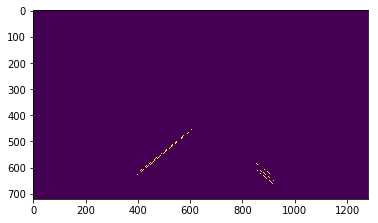

[282, 720, 636, 432]
[1009, 720, 641, 432]


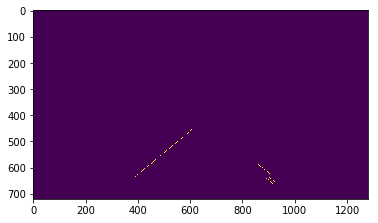

[284, 720, 634, 432]
[284, 720, 634, 432]


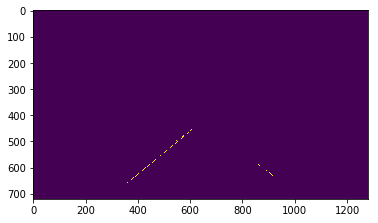

[284, 720, 634, 432]
[284, 720, 634, 432]


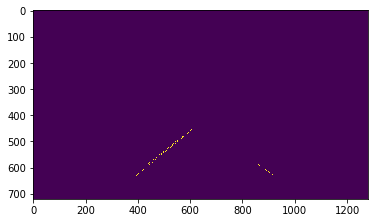

[275, 720, 633, 432]
[275, 720, 633, 432]


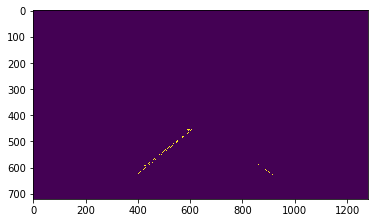

[276, 720, 632, 432]
[276, 720, 632, 432]


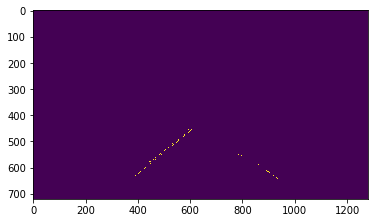

[272, 720, 634, 432]
[1043, 720, 647, 432]


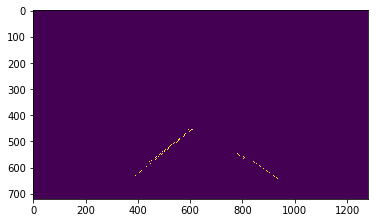

[273, 720, 635, 432]
[1052, 720, 628, 432]


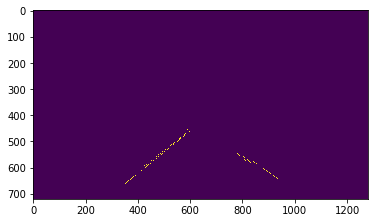

[274, 720, 633, 432]
[1047, 720, 632, 432]


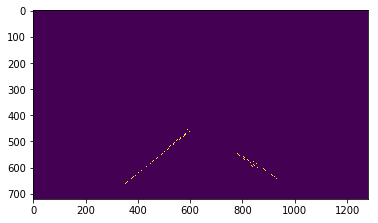

[281, 720, 631, 432]
[1007, 720, 647, 432]


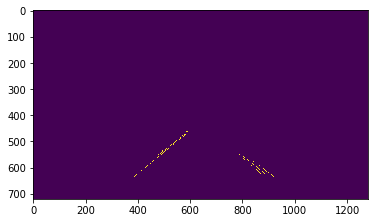

[265, 720, 636, 432]
[981, 720, 650, 432]


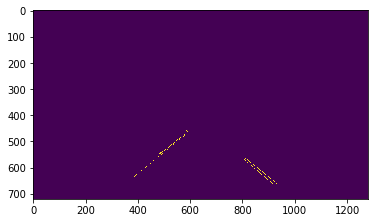

[271, 720, 633, 432]
[997, 720, 642, 432]


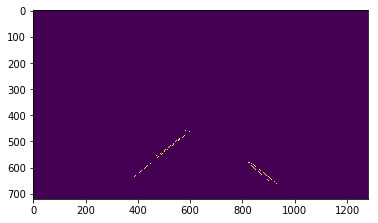

[275, 720, 634, 432]
[993, 720, 647, 432]


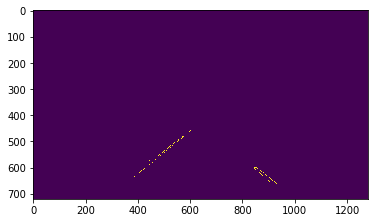

[276, 720, 634, 432]
[992, 720, 647, 432]


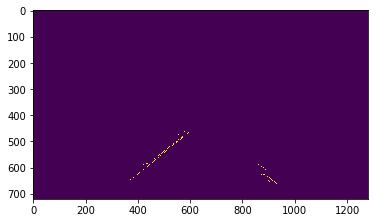

[276, 720, 639, 432]
[276, 720, 639, 432]


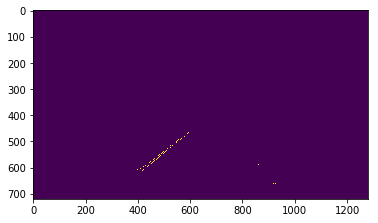

[280, 720, 636, 432]
[280, 720, 636, 432]


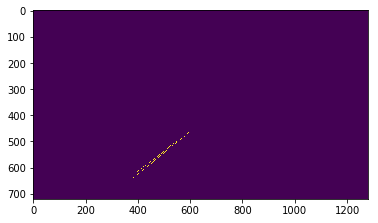

[268, 720, 640, 432]
[268, 720, 640, 432]


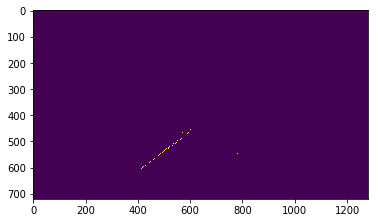

[260, 720, 641, 432]
[260, 720, 641, 432]


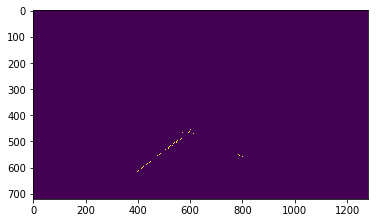

[260, 720, 637, 432]
[260, 720, 637, 432]


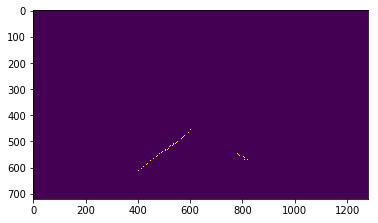

[266, 720, 636, 432]
[266, 720, 636, 432]


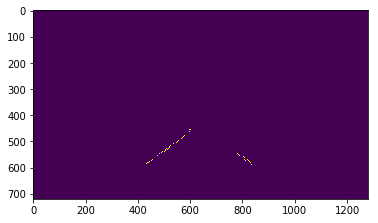

[257, 720, 638, 432]
[257, 720, 638, 432]


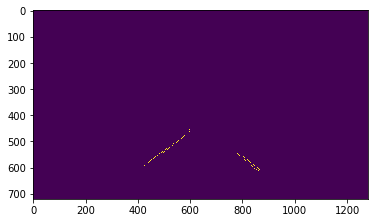

[264, 720, 635, 432]
[990, 720, 651, 432]


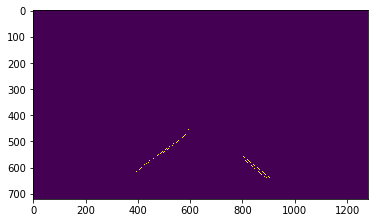

[254, 720, 640, 432]
[988, 720, 647, 432]


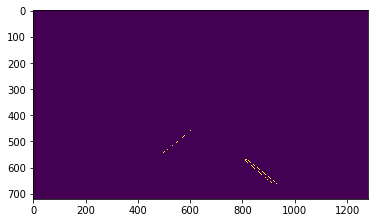

[279, 720, 635, 432]
[995, 720, 644, 432]


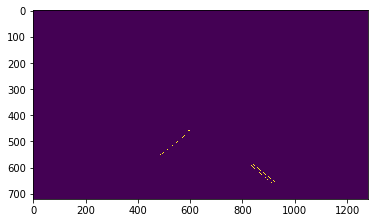

[280, 720, 635, 432]
[995, 720, 641, 432]


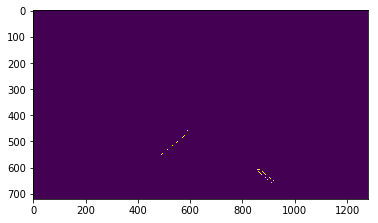

[279, 720, 636, 432]
[996, 720, 641, 432]


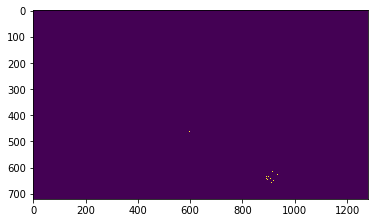

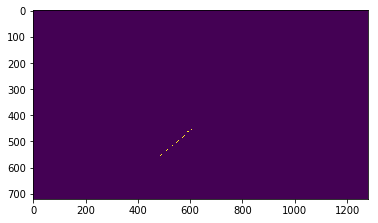

[282, 720, 635, 432]
[282, 720, 635, 432]


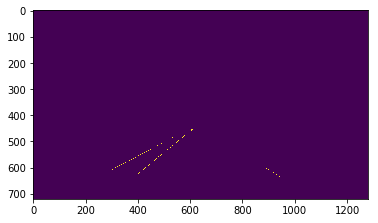

[233, 720, 636, 432]
[233, 720, 636, 432]


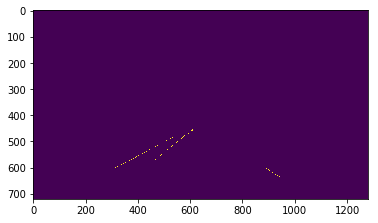

[206, 720, 634, 432]
[206, 720, 634, 432]


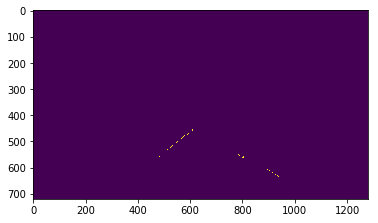

[281, 720, 635, 432]
[281, 720, 635, 432]


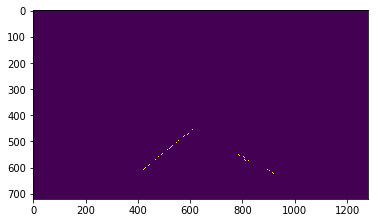

[280, 720, 635, 432]
[280, 720, 635, 432]


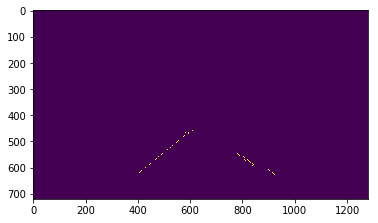

[279, 720, 637, 432]
[991, 720, 639, 432]


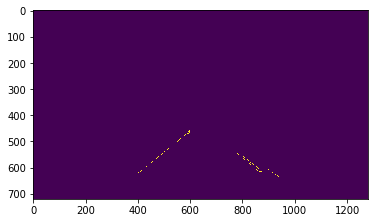

[279, 720, 635, 432]
[1003, 720, 638, 432]


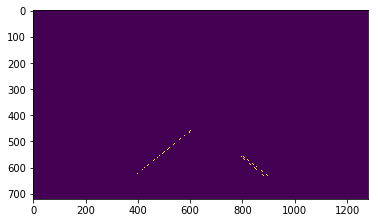

[277, 720, 634, 432]
[998, 720, 645, 432]


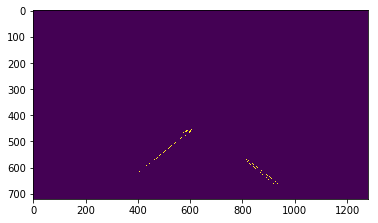

[275, 720, 635, 432]
[999, 720, 645, 432]


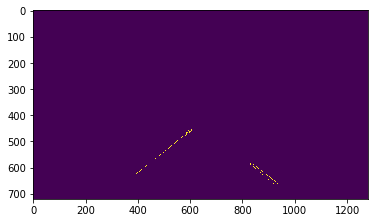

[274, 720, 634, 432]
[998, 720, 644, 432]


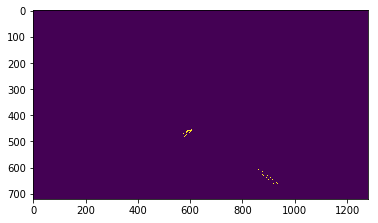

[274, 720, 634, 432]
[997, 720, 646, 432]


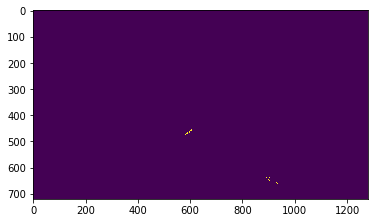

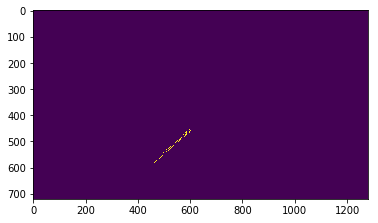

[295, 720, 634, 432]
[295, 720, 634, 432]


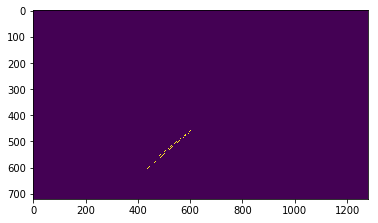

[290, 720, 634, 432]
[290, 720, 634, 432]


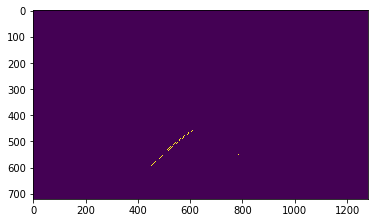

[285, 720, 636, 432]
[285, 720, 636, 432]


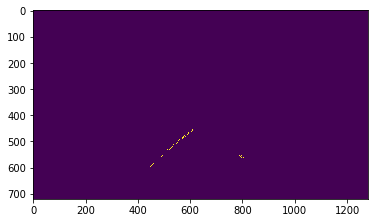

[288, 720, 637, 432]
[288, 720, 637, 432]


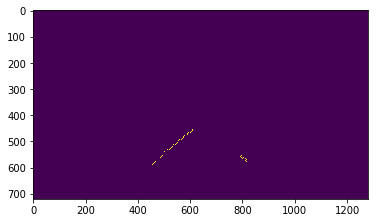

[295, 720, 634, 432]
[295, 720, 634, 432]


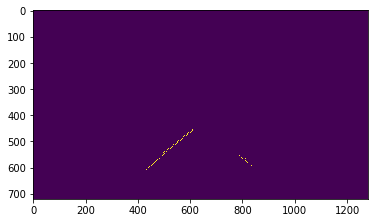

[289, 720, 637, 432]
[988, 720, 641, 432]


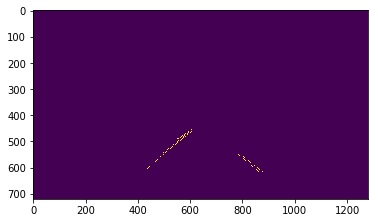

[292, 720, 635, 432]
[994, 720, 645, 432]


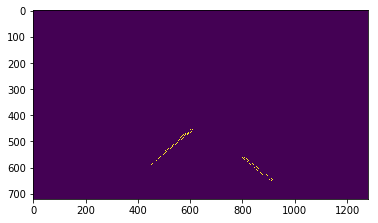

[282, 720, 638, 432]
[998, 720, 647, 432]


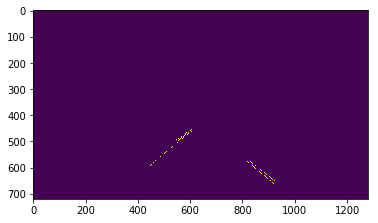

[293, 720, 638, 432]
[1002, 720, 642, 432]


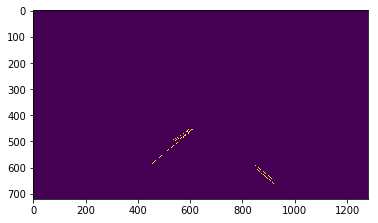

[287, 720, 638, 432]
[1001, 720, 646, 432]


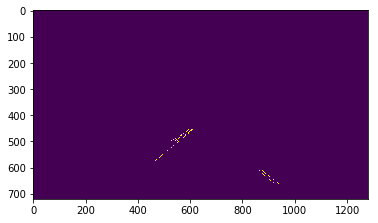

[292, 720, 636, 432]
[292, 720, 636, 432]


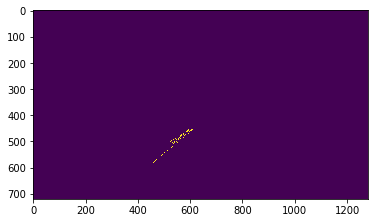

[279, 720, 633, 432]
[279, 720, 633, 432]


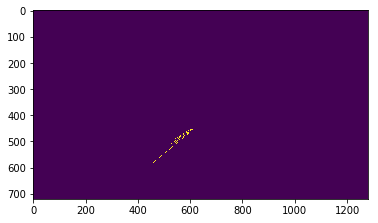

[235, 720, 637, 432]
[235, 720, 637, 432]


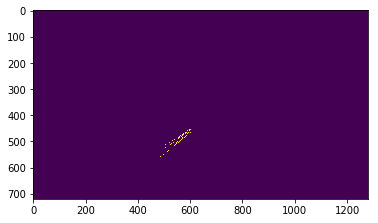

[251, 720, 637, 432]
[251, 720, 637, 432]


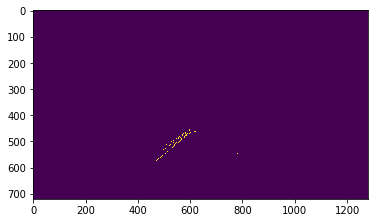

[245, 720, 637, 432]
[245, 720, 637, 432]


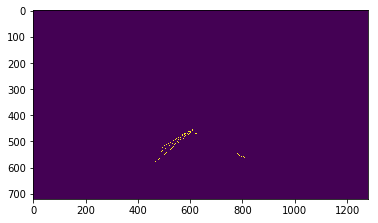

[259, 720, 638, 432]
[259, 720, 638, 432]


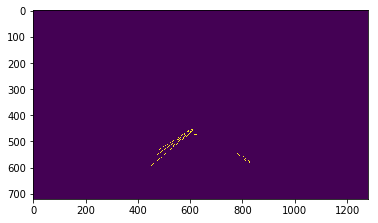

[255, 720, 640, 432]
[255, 720, 640, 432]


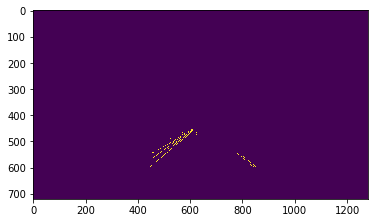

[241, 720, 640, 432]
[994, 720, 639, 432]


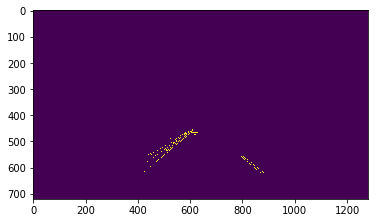

[279, 720, 638, 432]
[988, 720, 647, 432]


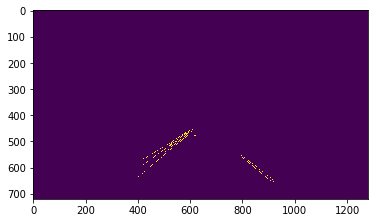

[261, 720, 640, 432]
[1000, 720, 644, 432]


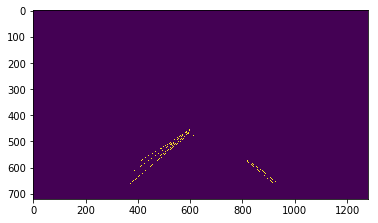

[238, 720, 639, 432]
[1002, 720, 644, 432]


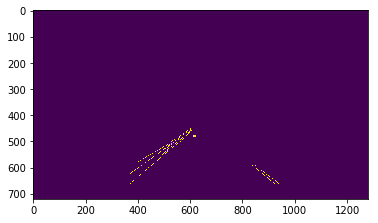

[245, 720, 639, 432]
[1005, 720, 640, 432]


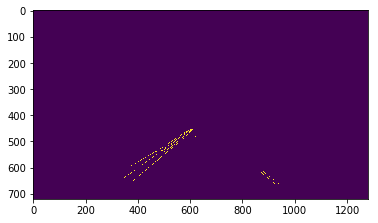

[249, 720, 637, 432]
[997, 720, 643, 432]


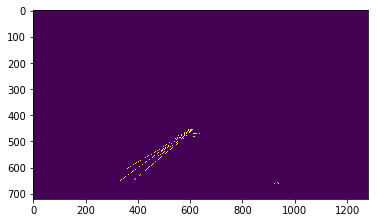

[232, 720, 638, 432]
[232, 720, 638, 432]


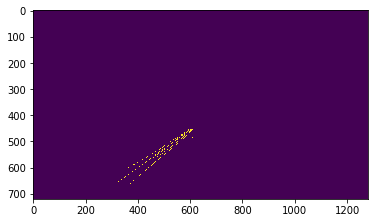

[243, 720, 637, 432]
[243, 720, 637, 432]


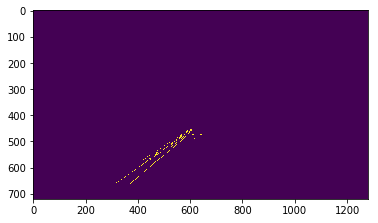

[241, 720, 636, 432]
[241, 720, 636, 432]


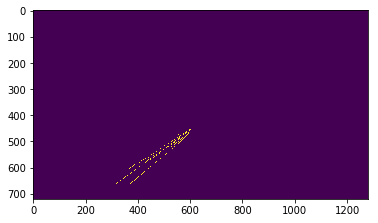

[245, 720, 635, 432]
[245, 720, 635, 432]


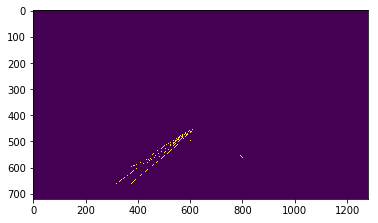

[260, 720, 636, 432]
[260, 720, 636, 432]


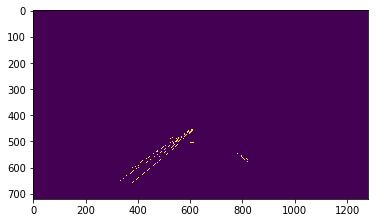

[268, 720, 641, 432]
[268, 720, 641, 432]


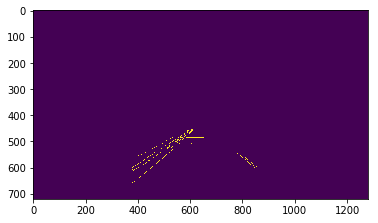

[255, 720, 640, 432]
[255, 720, 640, 432]


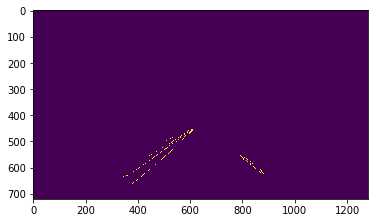

[249, 720, 644, 432]
[1094, 720, 619, 432]


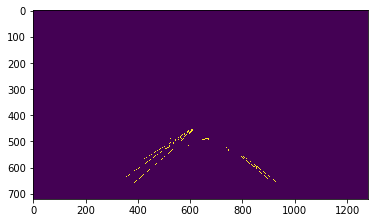

[266, 720, 639, 432]
[1001, 720, 645, 432]


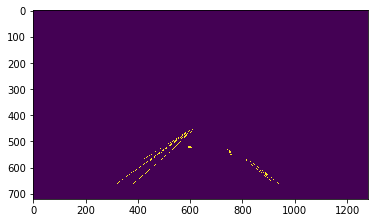

[227, 720, 641, 432]
[1073, 720, 629, 432]


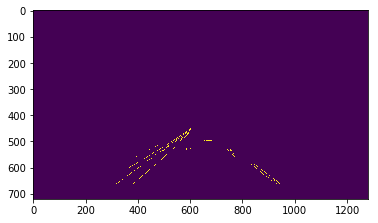

[185, 720, 652, 432]
[1009, 720, 639, 432]


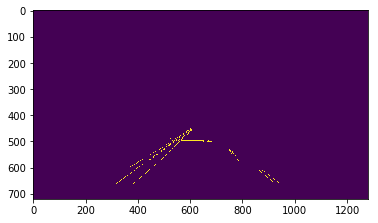

[254, 720, 635, 432]
[1145, 720, 609, 432]


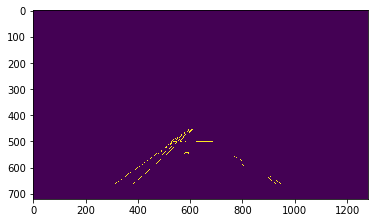

[263, 720, 634, 432]
[263, 720, 634, 432]


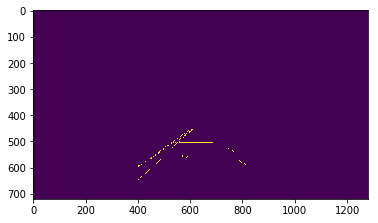

[276, 720, 630, 432]
[276, 720, 630, 432]


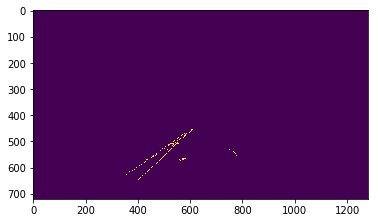

[273, 720, 633, 432]
[273, 720, 633, 432]


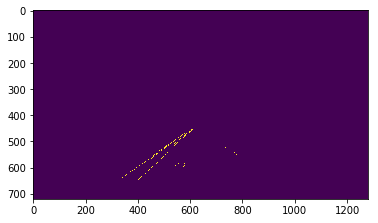

[220, 720, 650, 432]
[220, 720, 650, 432]


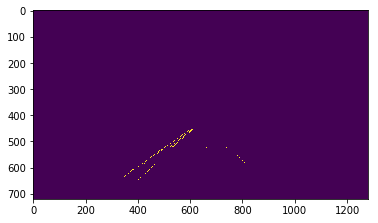

[229, 720, 650, 432]
[229, 720, 650, 432]


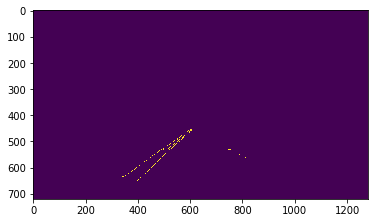

[251, 720, 632, 432]
[251, 720, 632, 432]


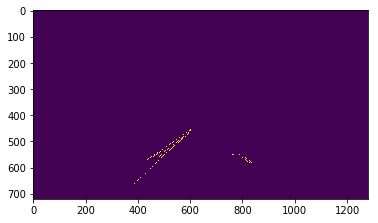

[296, 720, 634, 432]
[296, 720, 634, 432]


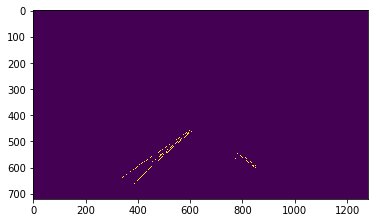

[279, 720, 632, 432]
[279, 720, 632, 432]


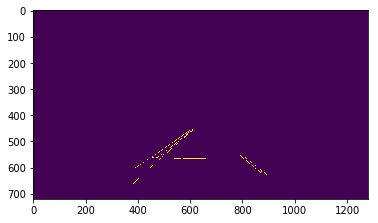

[259, 720, 654, 432]
[1002, 720, 644, 432]


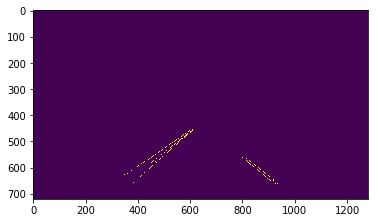

[270, 720, 634, 432]
[1000, 720, 649, 432]


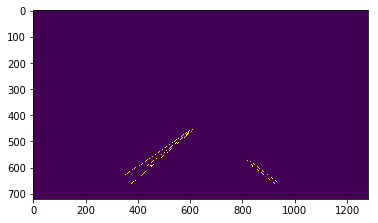

[278, 720, 639, 432]
[1005, 720, 644, 432]


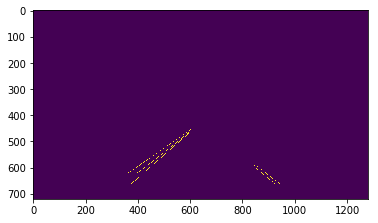

[284, 720, 635, 432]
[1007, 720, 640, 432]


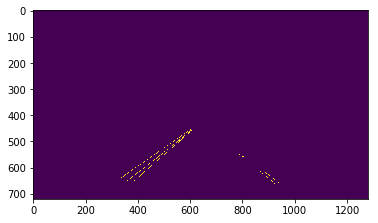

[255, 720, 635, 432]
[1009, 720, 642, 432]


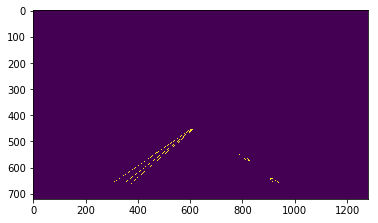

[242, 720, 636, 432]
[242, 720, 636, 432]


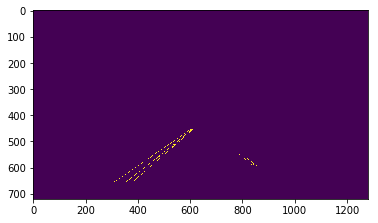

[265, 720, 638, 432]
[265, 720, 638, 432]


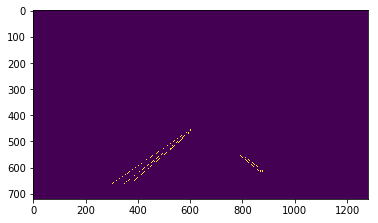

[274, 720, 638, 432]
[1007, 720, 643, 432]


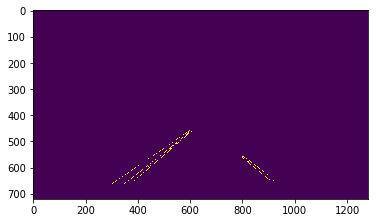

[280, 720, 637, 432]
[1002, 720, 645, 432]


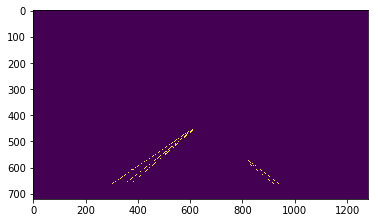

[268, 720, 638, 432]
[1002, 720, 641, 432]


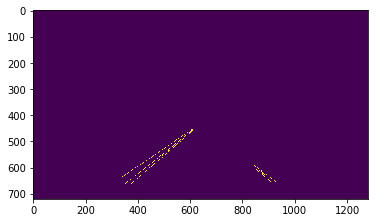

[278, 720, 638, 432]
[1001, 720, 639, 432]


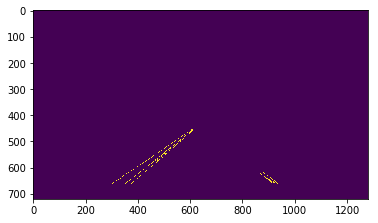

[273, 720, 640, 432]
[273, 720, 640, 432]


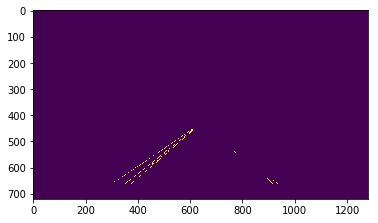

[278, 720, 638, 432]
[278, 720, 638, 432]


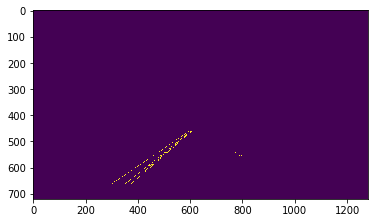

[276, 720, 638, 432]
[276, 720, 638, 432]


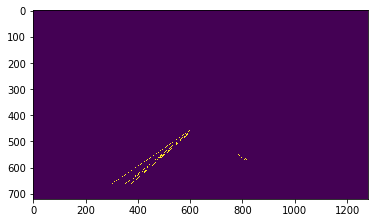

[273, 720, 638, 432]
[273, 720, 638, 432]


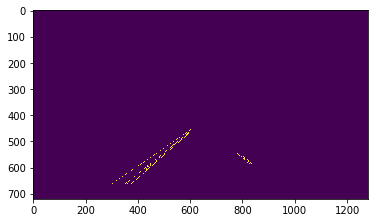

[270, 720, 636, 432]
[270, 720, 636, 432]


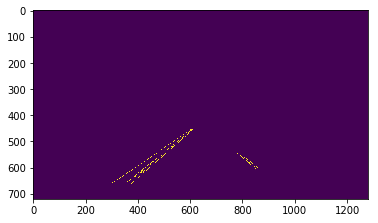

[254, 720, 637, 432]
[989, 720, 645, 432]


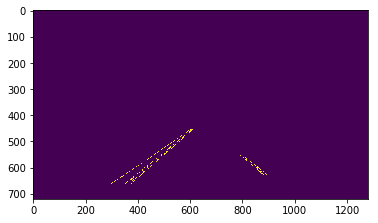

[268, 720, 636, 432]
[996, 720, 640, 432]


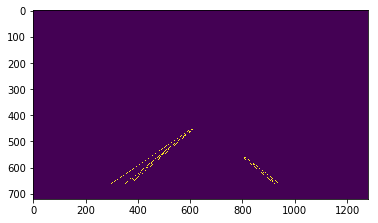

[259, 720, 632, 432]
[1005, 720, 645, 432]


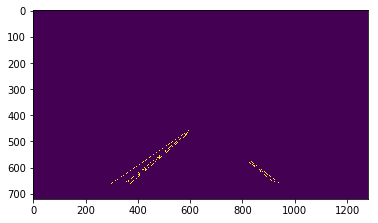

[264, 720, 634, 432]
[1007, 720, 646, 432]


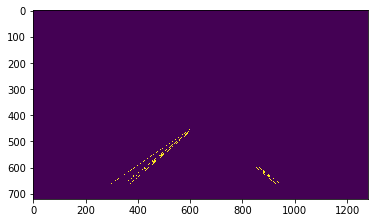

[258, 720, 634, 432]
[1009, 720, 647, 432]


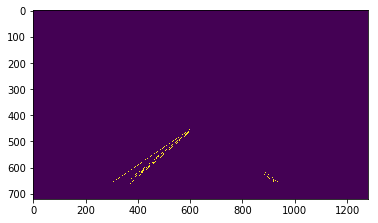

[278, 720, 632, 432]
[278, 720, 632, 432]


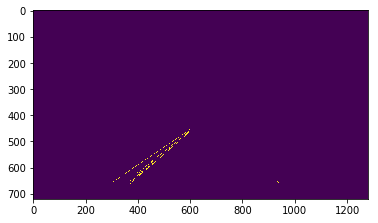

[277, 720, 632, 432]
[277, 720, 632, 432]


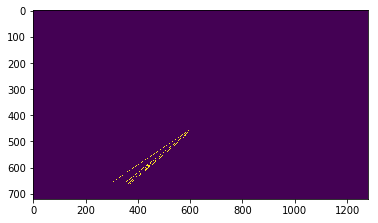

[262, 720, 632, 432]
[262, 720, 632, 432]


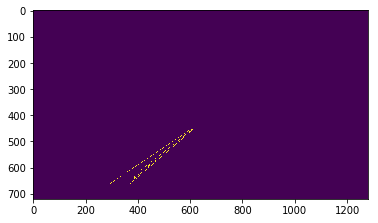

[265, 720, 635, 432]
[265, 720, 635, 432]


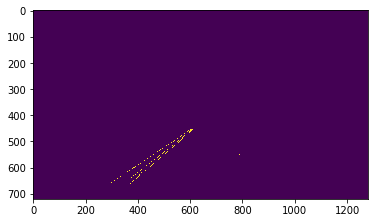

[271, 720, 635, 432]
[271, 720, 635, 432]


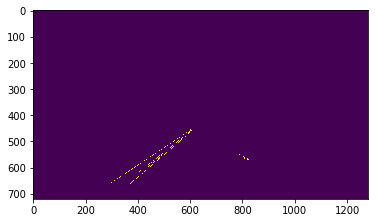

[260, 720, 638, 432]
[260, 720, 638, 432]


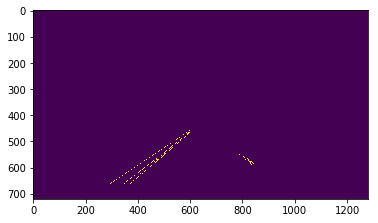

[265, 720, 639, 432]
[265, 720, 639, 432]


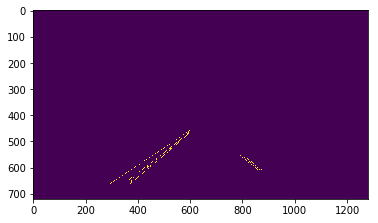

[258, 720, 641, 432]
[995, 720, 642, 432]


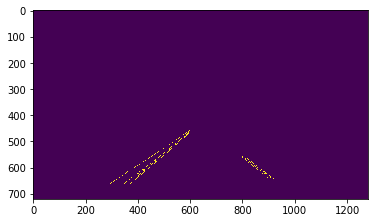

[269, 720, 639, 432]
[1009, 720, 641, 432]


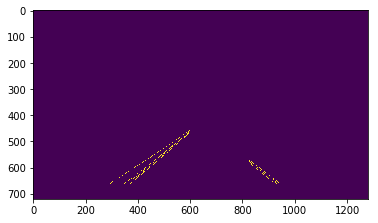

[270, 720, 639, 432]
[1009, 720, 640, 432]


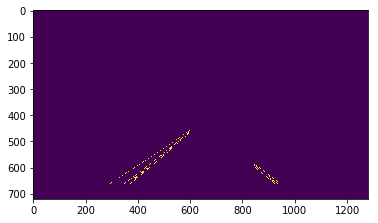

[271, 720, 637, 432]
[1010, 720, 644, 432]


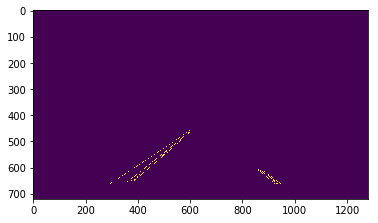

[276, 720, 639, 432]
[1011, 720, 638, 432]


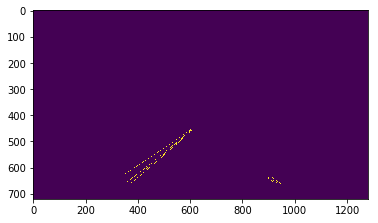

[262, 720, 639, 432]
[262, 720, 639, 432]


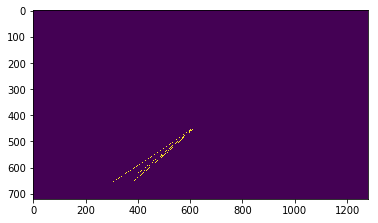

[256, 720, 639, 432]
[256, 720, 639, 432]


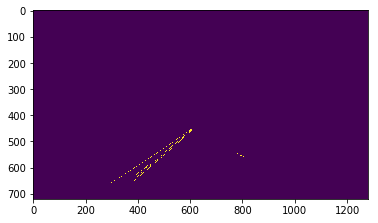

[271, 720, 637, 432]
[271, 720, 637, 432]


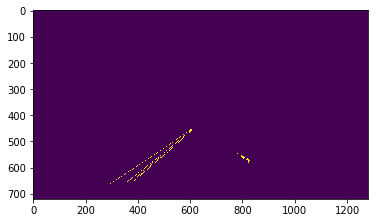

[281, 720, 638, 432]
[281, 720, 638, 432]


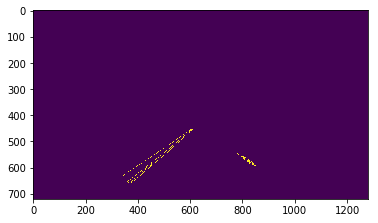

[266, 720, 636, 432]
[989, 720, 643, 432]


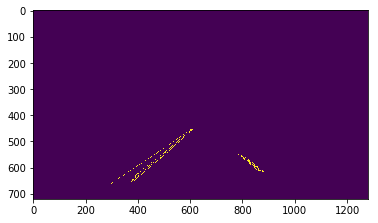

[266, 720, 638, 432]
[1001, 720, 643, 432]


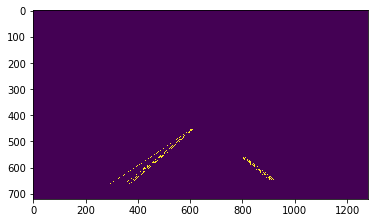

[279, 720, 637, 432]
[1004, 720, 643, 432]


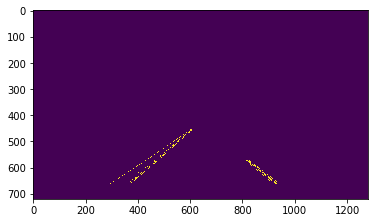

[278, 720, 637, 432]
[1001, 720, 647, 432]


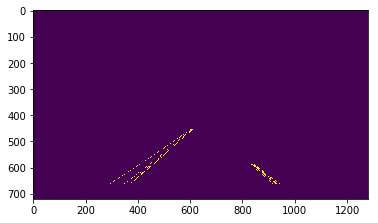

[271, 720, 636, 432]
[1001, 720, 646, 432]


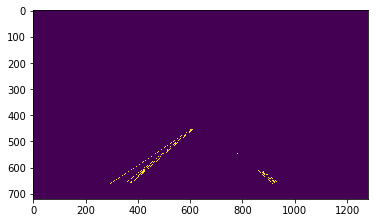

[261, 720, 638, 432]
[1009, 720, 642, 432]


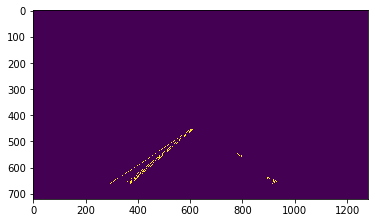

[272, 720, 634, 432]
[272, 720, 634, 432]


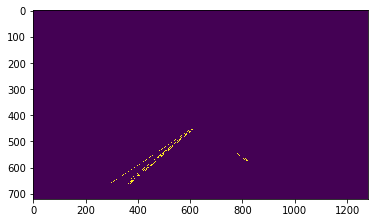

[264, 720, 633, 432]
[264, 720, 633, 432]


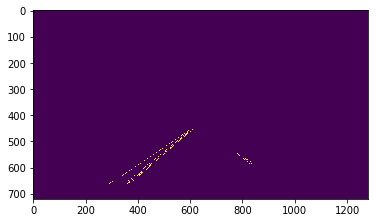

[274, 720, 633, 432]
[274, 720, 633, 432]


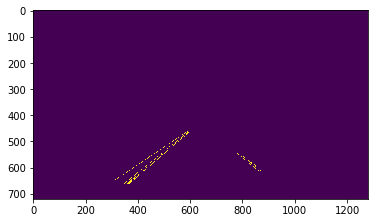

[265, 720, 634, 432]
[994, 720, 646, 432]


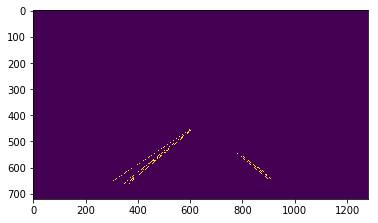

[268, 720, 633, 432]
[996, 720, 646, 432]


In [1]:
import cv2
import numpy as np
import warnings
import math
import matplotlib.pyplot as plt

%matplotlib inline

prev_left = 0
prev_line = 0
prev_x1 = 0
prev_x2 = 0

def make_points(image, line):
    global prev_line
    global prev_x1
    global prev_x2
    with warnings.catch_warnings():
        if np.any(np.isnan(line)):
            line = prev_line
        warnings.simplefilter("ignore", category=RuntimeWarning)
        slope, intercept = line
        y1 = int(image.shape[0]) # bottom of the image
        y2 = int(y1*3/5)         # slightly lower than the middle
        x1 = int((y1 - intercept)/slope)
        x2 = int((y2 - intercept)/slope)
        prev_line = line
        if x1 > 2000 or x1 < -2000:
            x1 = prev_x1
        if x2 > 2000 or x2 < -2000:
            x2 = prev_x2
        prev_x1 = x1
        prev_x2 = x2
    return [[x1, y1, x2, y2]]
 
def average_slope_intercept(image, lines):
    global prev_left
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        left_fit    = []
        right_fit   = []
        if lines is None:
            return None
        for line in lines:
            for x1, y1, x2, y2 in line:
                fit = np.polyfit((x1,x2), (y1,y2), 1)
                slope = fit[0]
                intercept = fit[1]
                if slope < 0: # y is reversed in image
                    left_fit.append((slope, intercept))
                else:
                    right_fit.append((slope, intercept))
        # add more weight to longer lines
        if len(left_fit) == 0:
            left_fit_average = prev_left
        else:
            left_fit_average = np.average(left_fit, axis=0)
        right_fit_average = np.average(right_fit, axis=0)
        left_line  = make_points(image, left_fit_average)
        right_line = make_points(image, right_fit_average)
        averaged_lines = [left_line, right_line]
        prev_left = left_fit_average
    return averaged_lines
 
def canny(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray,(5, 5),0)
    canny = cv2.Canny(blur, 50, 150)
    return canny
 
def display_lines(img,lines):
    line_image = np.zeros_like(img)
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
    return line_image
 
def region_of_interest(canny):
    height = canny.shape[0]
    width = canny.shape[1]
    mask = np.zeros_like(canny)
 

    if file == "Test 6.mp4":
         triangle = np.array([[
            (250, height-60),
            (650, 400),
            (1100, height-60),]])
    elif file == "Test 5.mp4":
        triangle = np.array([[
            (200, height-60),
            (600, 450),
            (1000, height-60),]], np.int32)
    elif file == "Test 8.mp4":
        triangle = np.array([[
            (200, height-60),
            (600, 450),
            (1100, height-60),]], np.int32)
    else:
        triangle = np.array([[
            (200, height),
            (550, 250),
            (1100, height),]], np.int32)
 
    cv2.fillPoly(mask, triangle, 255)
    masked_image = cv2.bitwise_and(canny, mask)
    return masked_image

def hough_lines(img):
    lines = cv2.HoughLinesP(img, 2, np.pi/180, 100, np.array([]), minLineLength=40,maxLineGap=5)
    return lines
 
# Video Example 
file = "Test 5.mp4"
cap = cv2.VideoCapture(file)
success, frame = cap.read()
height,width,layers = frame.shape
video=cv2.VideoWriter('Output.avi',-1,1,(width,height))
while success:
    success, frame = cap.read()
    if not success:
        break
    canny_image = canny(frame)
    cropped_canny = region_of_interest(canny_image)
    lines = hough_lines(cropped_canny)
    averaged_lines = average_slope_intercept(frame, lines)
    line_image = display_lines(frame, averaged_lines)
    combo_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)
    video.write(combo_image)
    cv2.imshow("result", combo_image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
     
video.release()
cap.release()
cv2.destroyAllWindows()